In [1]:
import anndata as ad 
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import scanpy
import seaborn as sns 
import sklearn.metrics.pairwise
import spikeinterface.core as sc
import spikeinterface.extractors as se
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm

n_uV_per_mV = 1000
n_mV_per_V = 1000
n_ms_per_s = 1000
window_ms, bin_ms = 100, 1.5

plot_format = 'pdf'
figure_folder = 'data/figures/longterm-v3'
os.makedirs(figure_folder, exist_ok=True)

In [2]:
threshold = 3.0
curated_units = {
    # subject, surgery_date, n_segment
    ('1_5', '20230627', 12): {
        # (shank, threshold): ([less confident units], [more confident units])
        4: {
            1: [2, 3, 5, 6, 9],
            2: [2, 3, 5, 6, 9],
            # 3: [2, 3, 5, 6, 11],
            15: [2, 3, 5, 6, 9],
            20: [2, 3, 5, 6, 10],
            22: [2, 3, 5, 6],
        },
        0: {
        },
        1: {
            1: [1, 4, 5, 6, 10],
            2: [   4, 5, 6, 10],
            4: [2, 4, 5, 6, 10],
            5: [2, 4, 5, 6, 10],
            6: [   4, 5, 6, 10],
        },
        2: {
            1: [2, 4, 5, 6, 11],
            2: [2, 4, 5, 6, 11],
            3: [2, 4, 5, 6, 10],
            4: [1, 4, 5, 6, 10],
            5: [1, 4, 5, 6, 10],
            8: [2, 4, 5, 6, 10],
        },
        3: {
            1: [1, 4, 5, 6, 10],
            2: [0, 4, 5, 6, 9],
            3: [   4, 5, 6, 11],
            4: [0, 4, 5, 7, 11],
            5: [0, 4, 5, 6, 11],
            6: [0, 4, 5, 6, 11],
        },
    }
}

plotted_units = {
    '1_5': [(2, 1), (2, 2), (2, 3), (3, 4), (2, 4), (2, 5), (2, 8), (3, 1), (3, 2), (4, 1), (4, 2), (4, 15)]
}

channel_indices = np.array([
    [ 5,  3,  1,  7,  9, 11], # 5
    [17, 15, 13, 19, 21, 23], # 4
    [29, 27, 25, 28, 26, 24], # 3
    [18, 20, 22, 16, 14, 12], # 2
    [ 6,  8, 10,  4,  2,  0], # 1
])
inter_electrode_distance = 50
n_total_lapse = 18 
n_shank = 5
n_channel = 6
lapses_plotted = [2, 6, 10, 14, 18]

n_unit = sum([len(shank_units) for shank_curated_units in curated_units.values() for shank_units in shank_curated_units.values()])

In [3]:
for (subject, surgery_date, n_segment), subject_curated_units in curated_units.items():
    surgery_date = datetime.datetime.strptime(surgery_date, '%Y%m%d')
    os.makedirs(f'data/processed/{subject}/adata', exist_ok=True)
    for shank, shank_curated_units in subject_curated_units.items():
        for unit_id, unit_segments in shank_curated_units.items():    
            if not os.path.isfile(f'data/processed/{subject}/adata/shank{shank}_unit{unit_id}.h5ad'):
                session_info = pd.read_csv(f'data/processed/{subject}/shank{shank}/session_info.csv')
                segment_lapses = [2+4*round(((datetime.datetime.strptime(path.split('/')[3], '%Y%m%d')-surgery_date).days - 14) / 28) for path in session_info['segment_path']]
                recordings = [sc.load_extractor(f'data/processed/{subject}/shank{shank}/recording/segment{segment}') for segment in range(n_segment)]
                sortings = [se.NpzSortingExtractor(f'data/processed/{subject}/shank{shank}/sorting{threshold}/sorter_output/segment{segment}_firings.npz') for segment in range(n_segment)]
                waveform_extractors = [sc.load_waveforms(folder=f'data/processed/{subject}/shank{shank}/waveform{threshold}/segment{segment}', with_recording=False, sorting=sortings[segment]) for segment in range(n_segment)]

                xs, labels = [], []
                for segment in unit_segments:
                    segment_waveforms = waveform_extractors[segment].get_waveforms(unit_id=unit_id)
                    segment_waveforms = segment_waveforms.reshape(segment_waveforms.shape[0], segment_waveforms.shape[1]*segment_waveforms.shape[2])
                    xs.append(segment_waveforms)
                    labels.append([segment_lapses[segment]] * len(segment_waveforms))
                xs = np.vstack(xs)
                labels = np.hstack(labels)
                unit_adata = ad.AnnData(X=xs, obs=pd.DataFrame({'lapse': labels}))
                scanpy.pp.neighbors(unit_adata, use_rep='X')
                scanpy.tl.umap(unit_adata)
                unit_adata.write_h5ad(f'data/processed/{subject}/adata/shank{shank}_unit{unit_id}.h5ad')

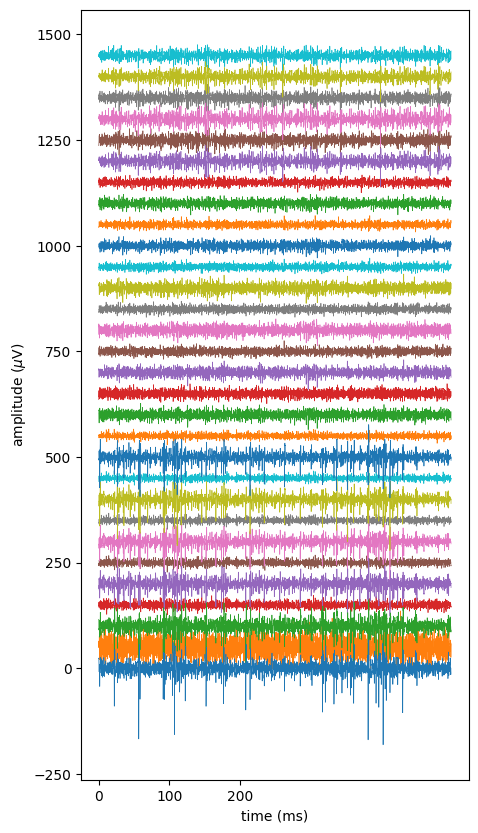

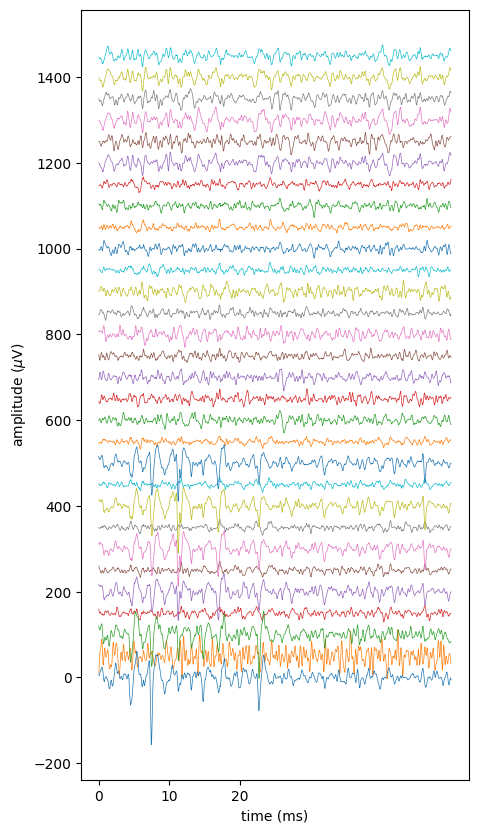

/tmp/ipykernel_711995/3453029812.py:72: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


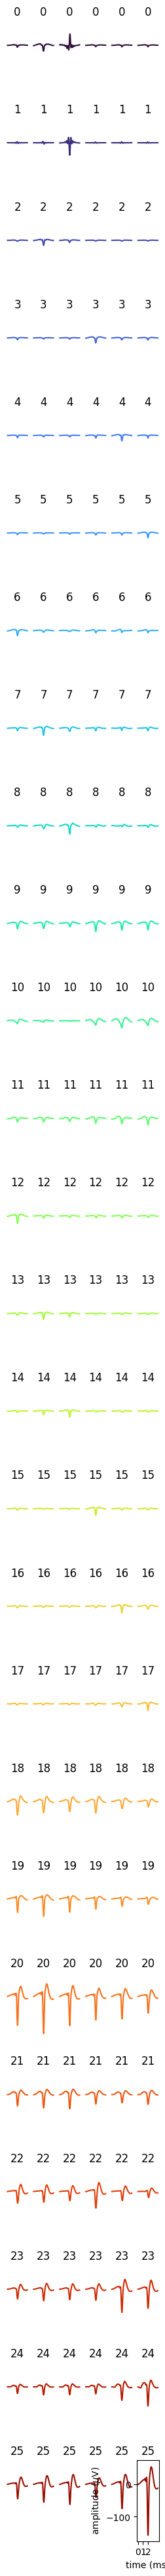

In [4]:
# subject = '1_5'
# segment = 3
# recordings = [sc.load_extractor(f'data/processed/{subject}/shank{shank}/recording/segment{segment}') for shank in range(n_shank)]
# n_frames_per_ms = recordings[0].sampling_frequency / n_ms_per_s
# shank_gap = 100
# trace_gap = 50

# zoom_out_start_frame = int(674.5*recordings[0].sampling_frequency)
# zoom_out_end_frame = int(675*recordings[0].sampling_frequency)

# plt.figure(figsize=(5, 10))
# for shank in range(n_shank):
#     zoom_out_traces = recordings[shank].get_traces(start_frame=zoom_out_start_frame, end_frame=zoom_out_end_frame).T 
#     for trace_index, trace in enumerate(zoom_out_traces):
#         plt.plot(trace + trace_gap * recordings[shank].channel_ids[trace_index], linewidth=0.5, color=plt.cm.tab10(recordings[shank].channel_ids[trace_index] % 10))
# plt.xticks([0, n_frames_per_ms*100, n_frames_per_ms*200], [0, 100, 200])
# plt.xlabel('time (ms)')
# plt.ylabel(r'amplitude ($\mu$V)')
# plt.savefig(f'{figure_folder}/trace_zoom_out.{plot_format}')
# plt.show()
# plt.close()

# ################################################################################

# zoom_in_start_frame = int(674.6*recordings[0].sampling_frequency)
# zoom_in_end_frame = int(674.65*recordings[0].sampling_frequency)

# plt.figure(figsize=(5, 10))
# for shank in range(n_shank):
#     zoom_in_traces = recordings[shank].get_traces(start_frame=zoom_in_start_frame, end_frame=zoom_in_end_frame).T 
#     for trace_index, trace in enumerate(zoom_in_traces):
#         plt.plot(trace + trace_gap * recordings[shank].channel_ids[trace_index], linewidth=0.5, color=plt.cm.tab10(recordings[shank].channel_ids[trace_index] % 10))
# plt.xticks([0, n_frames_per_ms*10, n_frames_per_ms*20], [0, 10, 20])
# plt.xlabel('time (ms)')
# plt.ylabel(r'amplitude ($\mu$V)')
# plt.savefig(f'{figure_folder}/trace_zoom_in.{plot_format}')
# plt.show()
# plt.close()

# ################################################################################

# sortings = [se.NpzSortingExtractor(f'data/processed/{subject}/shank{shank}/sorting3.0/sorter_output/segment{segment}_firings.npz') for shank in range(n_shank)]
# waveform_extractors = [sc.load_waveforms(folder=f'data/processed/{subject}/shank{shank}/waveform3.0/segment{segment}', with_recording=False, sorting=sortings[shank]) for shank in range(n_shank)]

# zoomed_templates = []
# for shank in range(n_shank):
#     zoomed_unit_ids = []
#     for unit_id in sortings[shank].unit_ids:
#         if sortings[shank].get_unit_spike_train(unit_id=unit_id, start_frame=zoom_out_start_frame, end_frame=zoom_out_end_frame).size > 0:
#             zoomed_unit_ids.append(unit_id)

#     zoomed_templates.append(waveform_extractors[shank].get_all_templates(unit_ids=zoomed_unit_ids))
# zoomed_templates = np.vstack(zoomed_templates)

# gap = 500
# ncols = 6 # n_channels
# nrows = len(zoomed_templates)

# plt.figure(figsize=(3, 50))
# for unit_index in range(nrows):
#     for channel_index in range(ncols):
#         ax = plt.subplot(nrows, ncols, unit_index*ncols+channel_index+1)
#         ax.plot(zoomed_templates[unit_index, :, channel_index], color=plt.cm.turbo(unit_index/nrows))
#         ax.set_title(unit_index)
#         ax.set_ylim(-175, 75)
#         ax.set_axis_off()
# ax.set_xticks([0, n_frames_per_ms, n_frames_per_ms * 2], [0, 1, 2])
# ax.set_xlabel('time (ms)')
# ax.set_ylabel(r'amplitude ($\mu$V)')
# ax.set_axis_on()
# plt.savefig(f'{figure_folder}/trace_templates.{plot_format}')
# plt.tight_layout()
# plt.show()
# plt.close()

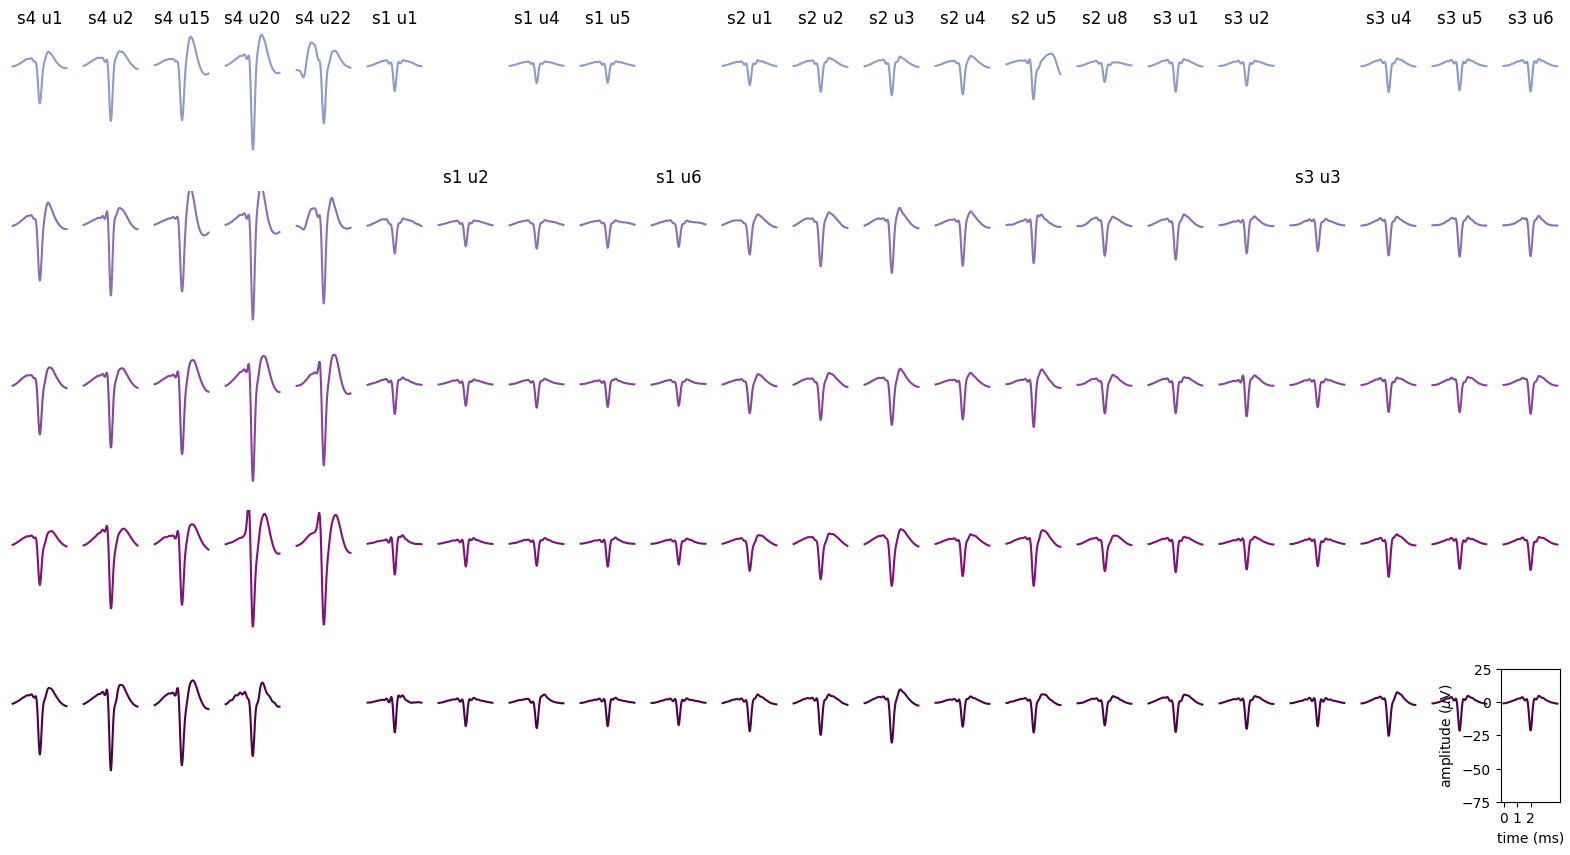

In [5]:
fig = plt.figure(figsize=(20, 10))
unit_index = 0
template_gap = 15
for (subject, surgery_date, n_segment), subject_curated_units in curated_units.items():
    surgery_date = datetime.datetime.strptime(surgery_date, '%Y%m%d')
    for shank, shank_curated_units in subject_curated_units.items():
        for unit_id, unit_segments in shank_curated_units.items():    
            session_info = pd.read_csv(f'data/processed/{subject}/shank{shank}/session_info.csv')
            segment_lapses = [2+4*round(((datetime.datetime.strptime(path.split('/')[3], '%Y%m%d')-surgery_date).days - 14) / 28) for path in session_info['segment_path']]
            recordings = [sc.load_extractor(f'data/processed/{subject}/shank{shank}/recording/segment{segment}') for segment in range(n_segment)]
            sortings = [se.NpzSortingExtractor(f'data/processed/{subject}/shank{shank}/sorting{threshold}/sorter_output/segment{segment}_firings.npz') for segment in range(n_segment)]
            waveform_extractors = [sc.load_waveforms(folder=f'data/processed/{subject}/shank{shank}/waveform{threshold}/segment{segment}', with_recording=False, sorting=sortings[segment]) for segment in range(n_segment)]
            templates = np.array([waveform_extractors[segment].get_template(unit_id=unit_id) for segment in range(n_segment)])
            unit_locations = np.array([spost.compute_unit_locations(waveform_extractors[segment], load_if_exists=True)[unit_id-1] for segment in range(n_segment)])
            
            extremum_channels = [sc.get_template_extremum_channel(waveform_extractors[segment])[unit_id] for segment in range(n_segment)]
            extremum_channels = [np.where(channel_indices[shank] == extremum_channel)[0].item() for extremum_channel in extremum_channels]
            extremum_templates = np.array([waveform_extractors[segment].get_template(unit_id=unit_id)[:, extremum_channels[segment]] for segment in range(n_segment)])

            for plot_index, segment in enumerate(unit_segments):
                row = lapses_plotted.index(segment_lapses[segment])
                color = plt.cm.BuPu(0.42 + 0.58 * segment_lapses[segment]/n_total_lapse)
                ax = plt.subplot(len(lapses_plotted), n_unit, (row * n_unit)+unit_index+1)
                ax.plot(extremum_templates[segment], color=color)
                ax.set_ylim(-75, 25)
                ax.set_axis_off()
                if plot_index == 0: 
                    ax.set_title(f's{shank} u{unit_id}')
            unit_index += 1
ax.set_axis_on()
ax.set_xticks([0, n_frames_per_ms, n_frames_per_ms * 2], [0, 1, 2])
ax.set_xlabel('time (ms)')
ax.set_ylabel(r'amplitude ($\mu$V)')
plt.savefig(f'{figure_folder}/templates.{plot_format}')
plt.show()
plt.close()

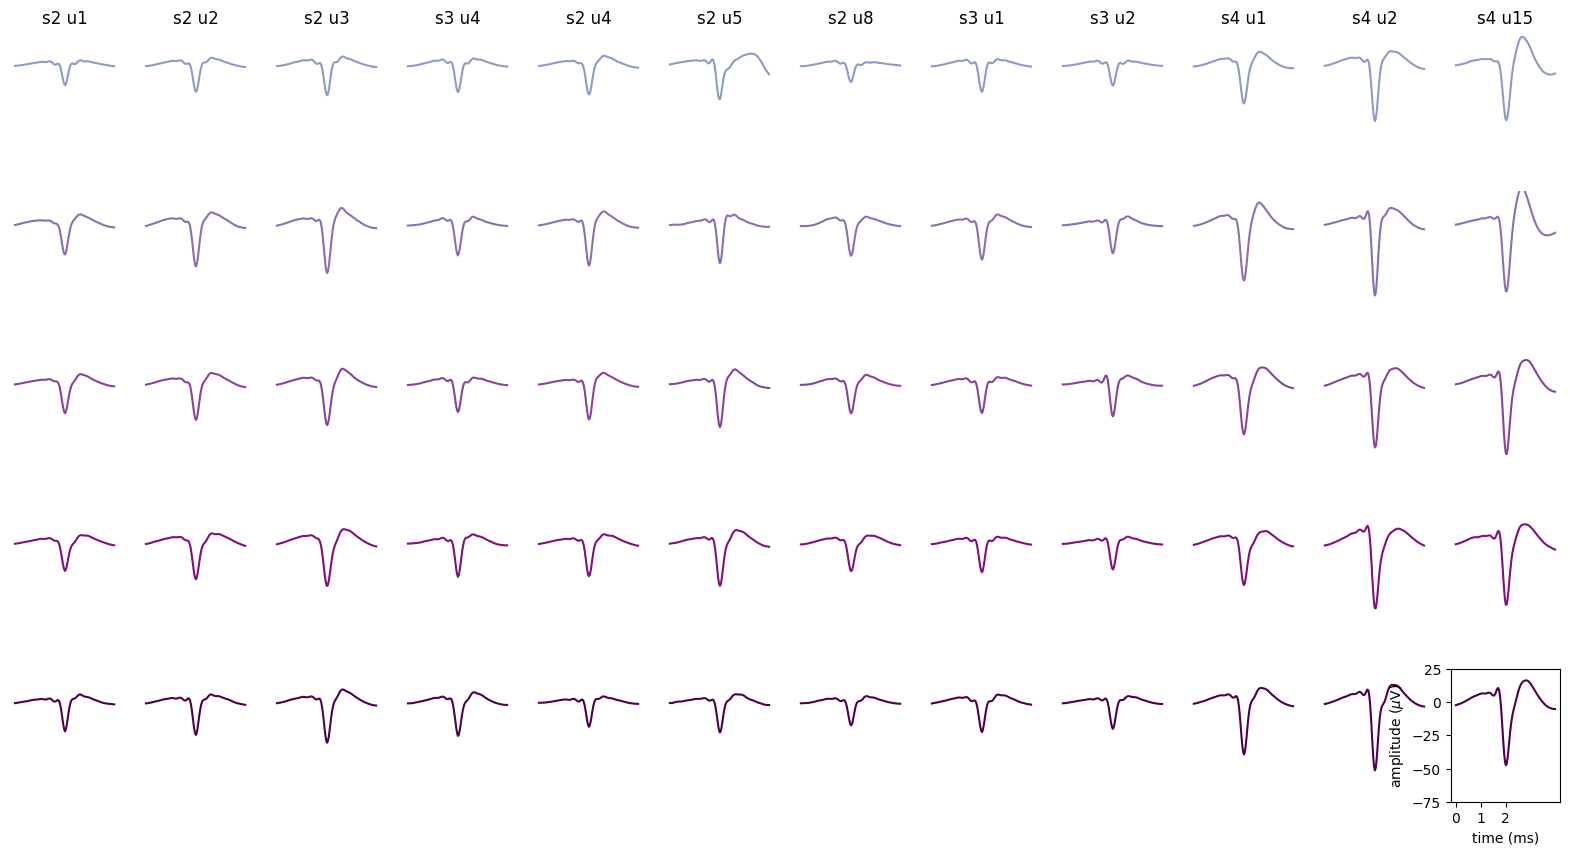

In [6]:
fig = plt.figure(figsize=(20, 10))
unit_index = 0
template_gap = 15
for key, subject_curated_units in curated_units.items():
    (subject, surgery_date, n_segment) = key
    surgery_date = datetime.datetime.strptime(surgery_date, '%Y%m%d')
    for (shank, unit_id) in plotted_units[subject]:
        unit_segments = curated_units[key][shank][unit_id]
        session_info = pd.read_csv(f'data/processed/{subject}/shank{shank}/session_info.csv')
        segment_lapses = [2+4*round(((datetime.datetime.strptime(path.split('/')[3], '%Y%m%d')-surgery_date).days - 14) / 28) for path in session_info['segment_path']]
        recordings = [sc.load_extractor(f'data/processed/{subject}/shank{shank}/recording/segment{segment}') for segment in range(n_segment)]
        sortings = [se.NpzSortingExtractor(f'data/processed/{subject}/shank{shank}/sorting{threshold}/sorter_output/segment{segment}_firings.npz') for segment in range(n_segment)]
        waveform_extractors = [sc.load_waveforms(folder=f'data/processed/{subject}/shank{shank}/waveform{threshold}/segment{segment}', with_recording=False, sorting=sortings[segment]) for segment in range(n_segment)]
        templates = np.array([waveform_extractors[segment].get_template(unit_id=unit_id) for segment in range(n_segment)])
        unit_locations = np.array([spost.compute_unit_locations(waveform_extractors[segment], load_if_exists=True)[unit_id-1] for segment in range(n_segment)])
        
        extremum_channels = [sc.get_template_extremum_channel(waveform_extractors[segment])[unit_id] for segment in range(n_segment)]
        extremum_channels = [np.where(channel_indices[shank] == extremum_channel)[0].item() for extremum_channel in extremum_channels]
        extremum_templates = np.array([waveform_extractors[segment].get_template(unit_id=unit_id)[:, extremum_channels[segment]] for segment in range(n_segment)])

        for plot_index, segment in enumerate(unit_segments):
            row = lapses_plotted.index(segment_lapses[segment])
            color = plt.cm.BuPu(0.42 + 0.58 * segment_lapses[segment]/n_total_lapse)
            ax = plt.subplot(len(lapses_plotted), len(plotted_units[subject]), (row * len(plotted_units[subject])+unit_index+1))
            ax.plot(extremum_templates[segment], color=color)
            ax.set_ylim(-75, 25)
            ax.set_axis_off()
            if plot_index == 0: 
                ax.set_title(f's{shank} u{unit_id}')
        unit_index += 1
ax.set_axis_on()
ax.set_xticks([0, n_frames_per_ms, n_frames_per_ms * 2], [0, 1, 2])
ax.set_xlabel('time (ms)')
ax.set_ylabel(r'amplitude ($\mu$V)')
plt.savefig(f'{figure_folder}/templates_arranged.{plot_format}')
plt.show()
plt.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


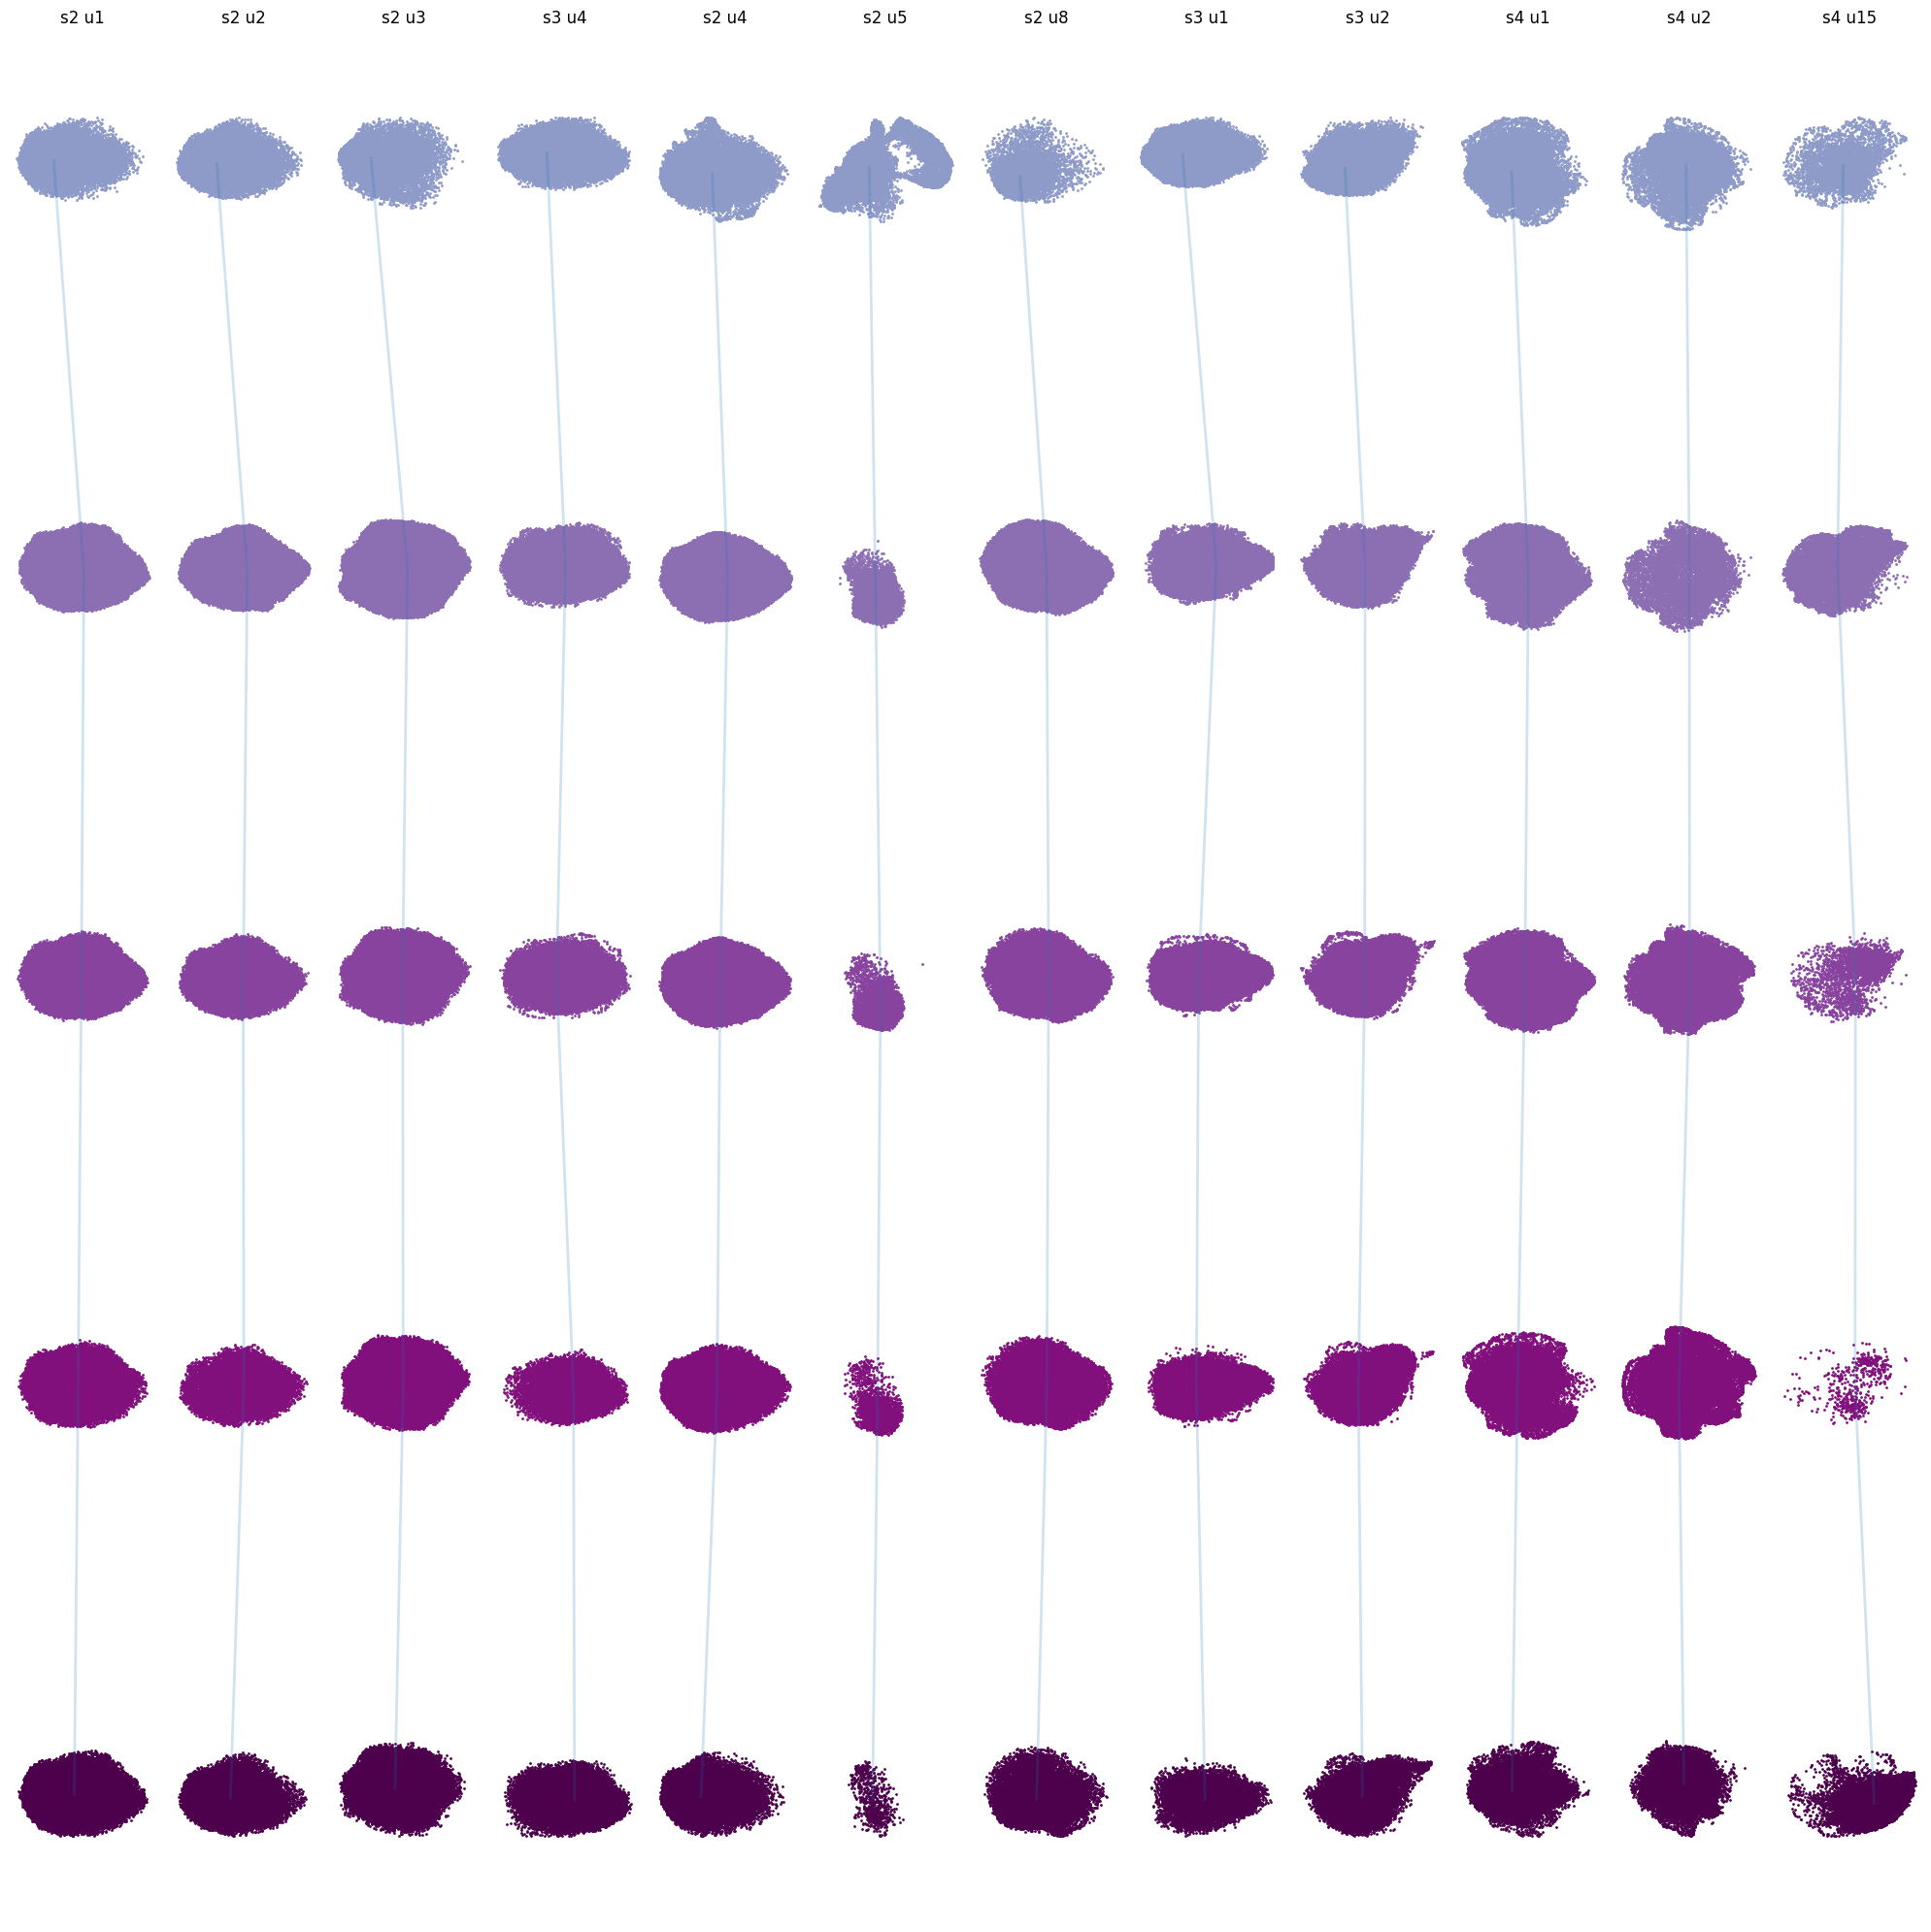

In [7]:
fig = plt.figure(figsize=(20, 20))
lapse_gap = 50
unit_index = 0
for key, subject_curated_units in curated_units.items():
    (subject, surgery_date, n_segment) = key
    surgery_date = datetime.datetime.strptime(surgery_date, '%Y%m%d')
    for (shank, unit_id) in plotted_units[subject]:
        unit_adata = ad.read_h5ad(f'data/processed/{subject}/adata/shank{shank}_unit{unit_id}.h5ad')
        shank_gap = -10
        means = []
        
        ax = plt.subplot(1, len(plotted_units[subject]), unit_index+1)
        ax.set_title(f's{shank} u{unit_id}')
        ax.set_axis_off()
        for plot_index, lapse in enumerate(lapses_plotted):
            lapse_adata = unit_adata[unit_adata.obs['lapse'] == lapse]
            row = lapses_plotted.index(lapse)
            color = plt.cm.BuPu(0.42 + 0.58 * lapse/n_total_lapse)

            ax.scatter(lapse_adata.obsm['X_umap'][:, 0], lapse_adata.obsm['X_umap'][:, 1] - row * lapse_gap, s=1, color=color)
            means.append([lapse_adata.obsm['X_umap'][:, 0].mean(), lapse_adata.obsm['X_umap'][:, 1].mean() - row * lapse_gap])
            
        means = np.array(means)
        ax.plot(means[:, 0], means[:, 1], linewidth=2, alpha=0.2, color='#8FB3C6')

        unit_index += 1
plt.tight_layout()
plt.savefig(f'{figure_folder}/umaps_arranged.pdf')
plt.savefig(f'{figure_folder}/umaps_arranged.eps')
plt.savefig(f'{figure_folder}/umaps_arranged.svg')
plt.savefig(f'{figure_folder}/umaps_arranged.png', dpi=1200, transparent=True)
plt.show()
plt.close()

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_189322/3098391800.py:58: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


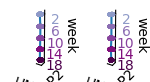

In [49]:
fig = plt.figure(figsize=(20, 20))
unit_index = 0
for (subject, surgery_date, n_segment), subject_curated_units in curated_units.items():
    surgery_date = datetime.datetime.strptime(surgery_date, '%Y%m%d')
    for shank, shank_curated_units in subject_curated_units.items():
        for unit_id, unit_segments in shank_curated_units.items():    
            if unit_index >= 2: break
            session_info = pd.read_csv(f'data/processed/{subject}/shank{shank}/session_info.csv')
            segment_lapses = [2+4*round(((datetime.datetime.strptime(path.split('/')[3], '%Y%m%d')-surgery_date).days - 14) / 28) for path in session_info['segment_path']]
            recordings = [sc.load_extractor(f'data/processed/{subject}/shank{shank}/recording/segment{segment}') for segment in range(n_segment)]
            sortings = [se.NpzSortingExtractor(f'data/processed/{subject}/shank{shank}/sorting{threshold}/sorter_output/segment{segment}_firings.npz') for segment in range(n_segment)]
            waveform_extractors = [sc.load_waveforms(folder=f'data/processed/{subject}/shank{shank}/waveform{threshold}/segment{segment}', with_recording=False, sorting=sortings[segment]) for segment in range(n_segment)]

            xs, labels = [], []
            for segment in unit_segments:
                segment_waveforms = waveform_extractors[segment].get_waveforms(unit_id=unit_id)
                segment_waveforms = segment_waveforms.reshape(segment_waveforms.shape[0], segment_waveforms.shape[1]*segment_waveforms.shape[2])
                xs.append(segment_waveforms)
                labels.append([segment_lapses[segment]] * len(segment_waveforms))
            xs = np.vstack(xs)
            labels = np.hstack(labels)
            unit_adata = ad.AnnData(X=xs, obs=pd.DataFrame({'lapse': labels}))
            scanpy.pp.neighbors(unit_adata, use_rep='X')
            scanpy.tl.umap(unit_adata)

            ax = plt.subplot(1, n_unit, unit_index+1, projection='3d')
            ax.set_box_aspect((1, 1, 10))
            ax.grid(False)
            ax.xaxis.pane.fill = False
            ax.yaxis.pane.fill = False
            ax.zaxis.pane.fill = False
            ax.xaxis.pane.set_edgecolor('w')
            ax.yaxis.pane.set_edgecolor('w')
            ax.zaxis.pane.set_edgecolor('w')

            shank_gap = -10
            means = []
            for plot_index, lapse in enumerate(lapses_plotted):
                lapse_adata = unit_adata[unit_adata.obs['lapse'] == lapse]
                
                ax.scatter3D(lapse_adata.obsm['X_umap'][:, 0], lapse_adata.obsm['X_umap'][:, 1], plot_index * shank_gap, s=1, color=plt.cm.BuPu(0.42 + 0.58 * lapse / n_total_lapse))
                
                means.append([lapse_adata.obsm['X_umap'][:, 0].mean(), lapse_adata.obsm['X_umap'][:, 1].mean(), plot_index * shank_gap])
                
            means = np.array(means)
            ax.plot3D(means[:, 0], means[:, 1], means[:, 2])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks(np.arange(len(lapses_plotted)) * shank_gap, lapses_plotted)
            ax.set_xlabel('UMAP1', labelpad=-10)
            ax.set_ylabel('UMAP2', labelpad=-10)
            ax.set_zlabel('week', rotation=270, labelpad=50)
            ax.tick_params(axis='z', pad=20)
            for lapse_index, ticklabel in enumerate(ax.get_zticklabels()):
                ticklabel.set_color(plt.cm.BuPu(0.42 + 0.58 * lapses_plotted[lapse_index] / n_total_lapse))

            unit_index += 1
plt.tight_layout()
plt.show()
plt.close()

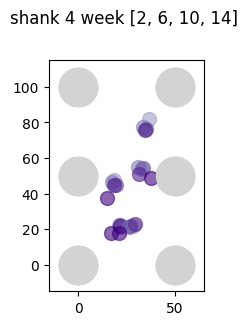

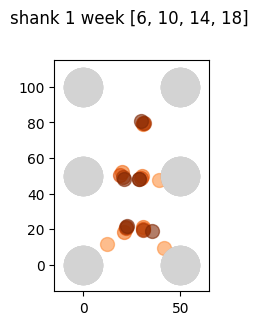

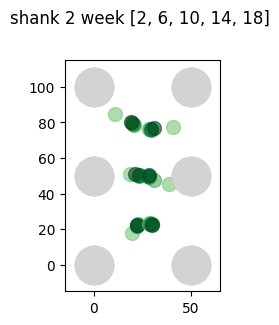

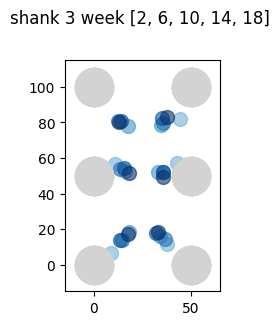

In [43]:
cmaps = {
    0: plt.cm.Reds,
    1: plt.cm.Oranges,
    2: plt.cm.Greens,
    3: plt.cm.Blues,
    4: plt.cm.Purples,
    5: plt.cm.Greys,
}
for (subject, surgery_date, n_segment), subject_curated_units in curated_units.items():
    surgery_date = datetime.datetime.strptime(surgery_date, '%Y%m%d')
    for shank, shank_curated_units in subject_curated_units.items():
        if len(shank_curated_units) > 0:
            fig = plt.figure(figsize=(2, 3))
            ax = plt.gca()
            for unit_index, (unit_id, unit_segments) in enumerate(shank_curated_units.items()):    
                session_info = pd.read_csv(f'data/processed/{subject}/shank{shank}/session_info.csv')
                segment_lapses = [2+4*round(((datetime.datetime.strptime(path.split('/')[3], '%Y%m%d')-surgery_date).days - 14) / 28) for path in session_info['segment_path']]
                recordings = [sc.load_extractor(f'data/processed/{subject}/shank{shank}/recording/segment{segment}') for segment in range(n_segment)]
                sortings = [se.NpzSortingExtractor(f'data/processed/{subject}/shank{shank}/sorting{threshold}/sorter_output/segment{segment}_firings.npz') for segment in range(n_segment)]
                waveform_extractors = [sc.load_waveforms(folder=f'data/processed/{subject}/shank{shank}/waveform{threshold}/segment{segment}', with_recording=False, sorting=sortings[segment]) for segment in range(n_segment)]
                unit_locations = np.array([spost.compute_unit_locations(waveform_extractors[segment], load_if_exists=True)[unit_id-1] for segment in range(n_segment)])

                ax.scatter(
                    [0, 0, 0, inter_electrode_distance, inter_electrode_distance, inter_electrode_distance],
                    [0, inter_electrode_distance, inter_electrode_distance*2, 0, inter_electrode_distance, inter_electrode_distance*2],
                    s=750, color='lightgray')
                # for unit_location
                for segment in unit_segments:
                    color = cmaps[shank](0.42 + 0.58 * segment_lapses[segment]/n_total_lapse)
                    ax.scatter(unit_locations[segment, 0], unit_locations[segment, 1], color=color, alpha=0.6, s=100, label=segment_lapses[segment])
            ax.set_xlim(-15, 65)
            ax.set_ylim(-15, 115)
            fig.suptitle(f'shank {shank} week {[segment_lapses[segment] for segment in unit_segments]}', y=1.05)
            plt.show()
            plt.close()

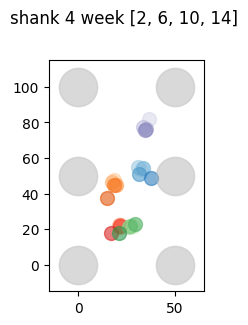

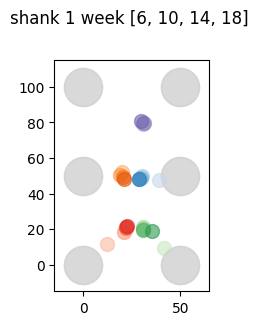

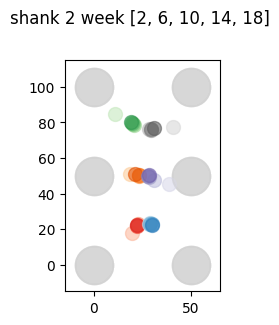

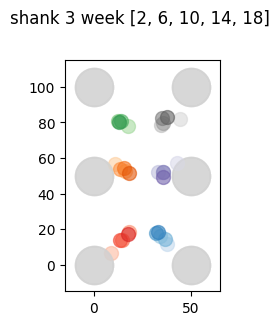

In [44]:
cmaps = {
    0: plt.cm.Reds,
    1: plt.cm.Oranges,
    2: plt.cm.Greens,
    3: plt.cm.Blues,
    4: plt.cm.Purples,
    5: plt.cm.Greys,
}
for (subject, surgery_date, n_segment), subject_curated_units in curated_units.items():
    surgery_date = datetime.datetime.strptime(surgery_date, '%Y%m%d')
    for shank, shank_curated_units in subject_curated_units.items():
        if len(shank_curated_units) > 0:
            fig = plt.figure(figsize=(2, 3))
            ax = plt.gca()
            for unit_index, (unit_id, unit_segments) in enumerate(shank_curated_units.items()):    
                session_info = pd.read_csv(f'data/processed/{subject}/shank{shank}/session_info.csv')
                segment_lapses = [2+4*round(((datetime.datetime.strptime(path.split('/')[3], '%Y%m%d')-surgery_date).days - 14) / 28) for path in session_info['segment_path']]
                recordings = [sc.load_extractor(f'data/processed/{subject}/shank{shank}/recording/segment{segment}') for segment in range(n_segment)]
                sortings = [se.NpzSortingExtractor(f'data/processed/{subject}/shank{shank}/sorting{threshold}/sorter_output/segment{segment}_firings.npz') for segment in range(n_segment)]
                waveform_extractors = [sc.load_waveforms(folder=f'data/processed/{subject}/shank{shank}/waveform{threshold}/segment{segment}', with_recording=False, sorting=sortings[segment]) for segment in range(n_segment)]
                unit_locations = np.array([spost.compute_unit_locations(waveform_extractors[segment], load_if_exists=True)[unit_id-1] for segment in range(n_segment)])

                ax.scatter(
                    [0, 0, 0, inter_electrode_distance, inter_electrode_distance, inter_electrode_distance],
                    [0, inter_electrode_distance, inter_electrode_distance*2, 0, inter_electrode_distance, inter_electrode_distance*2],
                    s=750, color='lightgray', alpha=0.3)
                # for unit_location
                for segment in unit_segments:
                    color = cmaps[unit_index](0.2 + 0.5 * segment_lapses[segment]/n_total_lapse)
                    ax.scatter(unit_locations[segment, 0], unit_locations[segment, 1], color=color, alpha=0.6, s=100, label=segment_lapses[segment])
            ax.set_xlim(-15, 65)
            ax.set_ylim(-15, 115)
            fig.suptitle(f'shank {shank} week {[segment_lapses[segment] for segment in unit_segments]}', y=1.05)
            plt.show()
            plt.close()

In [ ]:
cmaps = {
    0: plt.cm.Reds,
    1: plt.cm.Oranges,
    2: plt.cm.Greens,
    3: plt.cm.Blues,
    4: plt.cm.Purples,
    5: plt.cm.Greys,
}
for (subject, surgery_date, n_segment), subject_curated_units in curated_units.items():
    surgery_date = datetime.datetime.strptime(surgery_date, '%Y%m%d')
    for shank, shank_curated_units in subject_curated_units.items():
        if len(shank_curated_units) > 0:
            fig = plt.figure(figsize=(2, 3))
            ax = plt.gca()
            for unit_index, (unit_id, unit_segments) in enumerate(shank_curated_units.items()):    
                session_info = pd.read_csv(f'data/processed/{subject}/shank{shank}/session_info.csv')
                segment_lapses = [2+4*round(((datetime.datetime.strptime(path.split('/')[3], '%Y%m%d')-surgery_date).days - 14) / 28) for path in session_info['segment_path']]
                recordings = [sc.load_extractor(f'data/processed/{subject}/shank{shank}/recording/segment{segment}') for segment in range(n_segment)]
                sortings = [se.NpzSortingExtractor(f'data/processed/{subject}/shank{shank}/sorting{threshold}/sorter_output/segment{segment}_firings.npz') for segment in range(n_segment)]
                waveform_extractors = [sc.load_waveforms(folder=f'data/processed/{subject}/shank{shank}/waveform{threshold}/segment{segment}', with_recording=False, sorting=sortings[segment]) for segment in range(n_segment)]
                unit_locations = np.array([spost.compute_unit_locations(waveform_extractors[segment], load_if_exists=True)[unit_id-1] for segment in range(n_segment)])

                ax.scatter(
                    [0, 0, 0, inter_electrode_distance, inter_electrode_distance, inter_electrode_distance],
                    [0, inter_electrode_distance, inter_electrode_distance*2, 0, inter_electrode_distance, inter_electrode_distance*2],
                    s=750, color='lightgray', alpha=0.1, linewidth=0)
                # for unit_location
                for segment in [unit_segments[0], unit_segments[-1]]:
                    color = cmaps[unit_index](0.2 + 0.5 * segment_lapses[segment]/n_total_lapse)
                    ax.scatter(unit_locations[segment, 0], unit_locations[segment, 1], color=color, alpha=0.8, s=100, label=segment_lapses[segment], linewidth=0)
            ax.set_xlim(-15, 65)
            ax.set_ylim(-15, 115)
            fig.suptitle(f'shank {shank} week {[lapses_plotted[0], lapses_plotted[-1]]}', y=1.05)
            plt.show()
            plt.close()

In [ ]:
template_gap = 2
for (subject, surgery_date, n_segment), subject_curated_units in curated_units.items():
    surgery_date = datetime.datetime.strptime(surgery_date, '%Y%m%d')
    for shank, shank_curated_units in subject_curated_units.items():
        for unit_id, unit_segments in shank_curated_units.items():    
            session_info = pd.read_csv(f'data/processed/{subject}/shank{shank}/session_info.csv')
            segment_lapses = [2+4*round(((datetime.datetime.strptime(path.split('/')[3], '%Y%m%d')-surgery_date).days - 14) / 28) for path in session_info['segment_path']]
            recordings = [sc.load_extractor(f'data/processed/{subject}/shank{shank}/recording/segment{segment}') for segment in range(n_segment)]
            sortings = [se.NpzSortingExtractor(f'data/processed/{subject}/shank{shank}/sorting{threshold}/sorter_output/segment{segment}_firings.npz') for segment in range(n_segment)]
            waveform_extractors = [sc.load_waveforms(folder=f'data/processed/{subject}/shank{shank}/waveform{threshold}/segment{segment}', with_recording=False, sorting=sortings[segment]) for segment in range(n_segment)]
            templates = np.array([waveform_extractors[segment].get_template(unit_id=unit_id) for segment in range(n_segment)])
            unit_locations = np.array([spost.compute_unit_locations(waveform_extractors[segment], load_if_exists=True)[unit_id-1] for segment in range(n_segment)])

            fig = plt.figure(figsize=(6, 8))
            for segment in unit_segments:
                row = lapses_plotted.index(segment_lapses[segment])
                color = plt.cm.BuPu(0.42 + 0.58 * segment_lapses[segment]/n_total_lapse)
                for channel in range(n_channel):
                    plot_index = {0:7, 1:4, 2:1, 3:8, 4:5, 5:2}[channel]
                    ax = plt.subplot(3, 3, plot_index)
                    ax.plot(np.arange(templates.shape[1]), templates[segment, :, channel] + row * template_gap, color=color)
                    ax.set_ylim(templates.min(), templates.max()+len(lapses_plotted)*template_gap)
                    ax.set_axis_off()

            ax = plt.subplot(1, 3, 3)
            ax.scatter(
                [0, 0, 0, inter_electrode_distance, inter_electrode_distance, inter_electrode_distance],
                [0, inter_electrode_distance, inter_electrode_distance*2, 0, inter_electrode_distance, inter_electrode_distance*2],
                s=750, color='lightgray')
            # for unit_location
            for segment in unit_segments:
                color = plt.cm.BuPu(0.42 + 0.58 * segment_lapses[segment]/n_total_lapse)
                ax.scatter(unit_locations[segment, 0], unit_locations[segment, 1], color=color, alpha=0.6, s=100, label=segment_lapses[segment])
            ax.set_xlim(-15, 65)
            ax.set_ylim(-15, 115)
            plt.legend(bbox_to_anchor=(0.5, 1.5))
            fig.suptitle(f'shank {shank} unit {unit_id} week {[segment_lapses[segment] for segment in unit_segments]}', y=1.05)
            # plt.tight_layout()
            plt.show()
            plt.close()

In [ ]:
template_gap = 5
for (subject, surgery_date, n_segment), subject_curated_units in curated_units.items():
    surgery_date = datetime.datetime.strptime(surgery_date, '%Y%m%d')
    for shank, shank_curated_units in subject_curated_units.items():
        for unit_id, unit_segments in shank_curated_units.items():    
            session_info = pd.read_csv(f'data/processed/{subject}/shank{shank}/session_info.csv')
            segment_lapses = [2+4*round(((datetime.datetime.strptime(path.split('/')[3], '%Y%m%d')-surgery_date).days - 14) / 28) for path in session_info['segment_path']]
            recordings = [sc.load_extractor(f'data/processed/{subject}/shank{shank}/recording/segment{segment}') for segment in range(n_segment)]
            sortings = [se.NpzSortingExtractor(f'data/processed/{subject}/shank{shank}/sorting{threshold}/sorter_output/segment{segment}_firings.npz') for segment in range(n_segment)]
            waveform_extractors = [sc.load_waveforms(folder=f'data/processed/{subject}/shank{shank}/waveform{threshold}/segment{segment}', with_recording=False, sorting=sortings[segment]) for segment in range(n_segment)]
            templates = np.array([waveform_extractors[segment].get_template(unit_id=unit_id) for segment in range(n_segment)])
            unit_locations = np.array([spost.compute_unit_locations(waveform_extractors[segment], load_if_exists=True)[unit_id-1] for segment in range(n_segment)])

            fig = plt.figure(figsize=(8, 8))
            for segment in unit_segments:
                row = lapses_plotted.index(segment_lapses[segment])
                color = plt.cm.BuPu(0.42 + 0.58 * segment_lapses[segment]/n_total_lapse)
                for channel in range(n_channel):
                    plot_index = {0:7, 1:4, 2:1, 3:9, 4:6, 5:3}[channel]
                    ax = plt.subplot(3, 3, plot_index)
                    ax.plot(np.arange(templates.shape[1]), templates[segment, :, channel] + row * template_gap, color=color)
                    ax.set_title(f'segment {segment}')
                    ax.set_ylim(templates.min(), templates.max()+len(lapses_plotted)*template_gap)
                    ax.set_axis_off()
            ax.set_axis_on()

            ax = plt.subplot(1, 3, 2)
            ax.scatter(
                [0, 0, 0, inter_electrode_distance, inter_electrode_distance, inter_electrode_distance],
                [0, inter_electrode_distance, inter_electrode_distance*2, 0, inter_electrode_distance, inter_electrode_distance*2],
                s=750, color='lightgray')
            # for unit_location
            for segment in unit_segments:
                color = plt.cm.BuPu(0.42 + 0.58 * segment_lapses[segment]/n_total_lapse)
                ax.scatter(unit_locations[segment, 0], unit_locations[segment, 1], color=color, alpha=0.6, s=100, label=segment_lapses[segment])
            ax.set_xlim(-15, 65)
            ax.set_ylim(-15, 115)
            plt.legend(bbox_to_anchor=(0.5, 1.5))
            fig.suptitle(f'shank {shank} unit {unit_id} week {[segment_lapses[segment] for segment in unit_segments]}', y=1.05)
            plt.tight_layout()
            plt.show()
            plt.close()

In [ ]:
template_gap = 2
for (subject, surgery_date, n_segment), subject_curated_units in curated_units.items():
    surgery_date = datetime.datetime.strptime(surgery_date, '%Y%m%d')
    for shank, shank_curated_units in subject_curated_units.items():
        for unit_id, unit_segments in shank_curated_units.items():    
            session_info = pd.read_csv(f'data/processed/{subject}/shank{shank}/session_info.csv')
            segment_lapses = [2+4*round(((datetime.datetime.strptime(path.split('/')[3], '%Y%m%d')-surgery_date).days - 14) / 28) for path in session_info['segment_path']]
            recordings = [sc.load_extractor(f'data/processed/{subject}/shank{shank}/recording/segment{segment}') for segment in range(n_segment)]
            sortings = [se.NpzSortingExtractor(f'data/processed/{subject}/shank{shank}/sorting{threshold}/sorter_output/segment{segment}_firings.npz') for segment in range(n_segment)]
            waveform_extractors = [sc.load_waveforms(folder=f'data/processed/{subject}/shank{shank}/waveform{threshold}/segment{segment}', with_recording=False, sorting=sortings[segment]) for segment in range(n_segment)]
            templates = np.array([waveform_extractors[segment].get_template(unit_id=unit_id) for segment in range(n_segment)])
            unit_locations = np.array([spost.compute_unit_locations(waveform_extractors[segment], load_if_exists=True)[unit_id-1] for segment in range(n_segment)])

            fig = plt.figure(figsize=(6, 8))
            ax = plt.gca()
            amplifier = 4
            for segment in unit_segments:
                row = lapses_plotted.index(segment_lapses[segment])
                color = plt.cm.turbo(segment_lapses[segment]/n_total_lapse)
                for channel in range(n_channel):
                    plot_index = {0:7, 1:4, 2:1, 3:9, 4:6, 5:3}[channel]
                    base_x, base_y = {0:(0, 0), 1:(0, 50), 2:(0, 100), 3:(50, 0), 4:(50, 50), 5:(50, 100)}[channel]
                    ax.plot(np.arange(templates.shape[1]) + base_x * amplifier - 60, templates[segment, :, channel] + row * template_gap*5 + base_y * amplifier, color=color)
                
            ax.scatter(
                [0, 0, 0, inter_electrode_distance * amplifier, inter_electrode_distance * amplifier, inter_electrode_distance * amplifier],
                [0, inter_electrode_distance * amplifier, inter_electrode_distance * amplifier*2, 0, inter_electrode_distance * amplifier, inter_electrode_distance * amplifier*2],
                s=5000, color='lightgray', alpha=0.3)
            # for unit_location
            for segment in unit_segments:
                color = plt.cm.turbo(segment_lapses[segment]/n_total_lapse)
                ax.scatter(unit_locations[segment, 0] * amplifier, unit_locations[segment, 1] * amplifier, color=color, alpha=0.6, s=1000)
            fig.suptitle(f'shank {shank} unit {unit_id} week {[segment_lapses[segment] for segment in unit_segments]}', y=1.05)
            # plt.xlim(-100, 600)
            # plt.ylim(-150, 1150)
            plt.tight_layout()
            plt.show()
            plt.close()

In [ ]:
template_gap = 2
for (subject, surgery_date, n_segment), subject_curated_units in curated_units.items():
    surgery_date = datetime.datetime.strptime(surgery_date, '%Y%m%d')
    for shank, shank_curated_units in subject_curated_units.items():
        for unit_id, unit_segments in shank_curated_units.items():    
            session_info = pd.read_csv(f'data/processed/{subject}/shank{shank}/session_info.csv')
            segment_lapses = [2+4*round(((datetime.datetime.strptime(path.split('/')[3], '%Y%m%d')-surgery_date).days - 14) / 28) for path in session_info['segment_path']]
            recordings = [sc.load_extractor(f'data/processed/{subject}/shank{shank}/recording/segment{segment}') for segment in range(n_segment)]
            sortings = [se.NpzSortingExtractor(f'data/processed/{subject}/shank{shank}/sorting{threshold}/sorter_output/segment{segment}_firings.npz') for segment in range(n_segment)]
            waveform_extractors = [sc.load_waveforms(folder=f'data/processed/{subject}/shank{shank}/waveform{threshold}/segment{segment}', with_recording=False, sorting=sortings[segment]) for segment in range(n_segment)]
            templates = np.array([waveform_extractors[segment].get_template(unit_id=unit_id) for segment in range(n_segment)])
            unit_locations = np.array([spost.compute_unit_locations(waveform_extractors[segment], load_if_exists=True)[unit_id-1] for segment in range(n_segment)])

            fig = plt.figure(figsize=(6, 8))
            ax = plt.gca()
            amplifier = 4.5
            for segment in unit_segments:
                row = lapses_plotted.index(segment_lapses[segment])
                color = plt.cm.BuPu(0.42 + 0.58 * segment_lapses[segment]/n_total_lapse)
                for channel in range(n_channel):
                    plot_index = {0:7, 1:4, 2:1, 3:9, 4:6, 5:3}[channel]
                    base_x, base_y = {0:(0, 0), 1:(0, 50), 2:(0, 100), 3:(50, 0), 4:(50, 50), 5:(50, 100)}[channel]
                    ax.plot(np.arange(templates.shape[1]) + base_x * amplifier - 60, templates[segment, :, channel] + row * template_gap*5 + base_y * amplifier, color=color)
                
            ax.scatter(
                [0, 0, 0, inter_electrode_distance * amplifier, inter_electrode_distance * amplifier, inter_electrode_distance * amplifier],
                [0, inter_electrode_distance * amplifier, inter_electrode_distance * amplifier*2, 0, inter_electrode_distance * amplifier, inter_electrode_distance * amplifier*2],
                s=5000, color='lightgray', alpha=0.3)
            # for unit_location
            for segment in unit_segments:
                color = plt.cm.BuPu(0.42 + 0.58 * segment_lapses[segment]/n_total_lapse)
                ax.scatter(unit_locations[segment, 0] * amplifier, unit_locations[segment, 1] * amplifier, color=color, alpha=0.6, s=1000)
            fig.suptitle(f'shank {shank} unit {unit_id} week {[segment_lapses[segment] for segment in unit_segments]}', y=1.05)
            # plt.xlim(-100, 600)
            # plt.ylim(-150, 1150)
            plt.tight_layout()
            plt.show()
            plt.close()

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/spikeinterface/postprocessing/template_metrics.py:223: RuntimeWarning: invalid value encountered in scalar divide
  ptratio = template[peak_idx] / template[trough_idx]
/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/spikeinterface/postprocessing/template_metrics.py:223: RuntimeWarning: invalid value encountered in scalar divide
  ptratio = template[peak_idx] / template[trough_idx]
/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/spikeinterface/postprocessing/template_metrics.py:223: RuntimeWarning: invalid value encountered in scalar divide
  ptratio = template[peak_idx] / template[trough_idx]
/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/spikeinterface/postprocessing/template_metrics.py:223: RuntimeWarning: invalid value encountered in scalar divide
  ptratio = template[peak_idx] / template[trough_idx]
/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-pa

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/spikeinterface/postprocessing/template_metrics.py:223: RuntimeWarning: invalid value encountered in scalar divide
  ptratio = template[peak_idx] / template[trough_idx]
/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/spikeinterface/postprocessing/template_metrics.py:223: RuntimeWarning: invalid value encountered in scalar divide
  ptratio = template[peak_idx] / template[trough_idx]
/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/spikeinterface/postprocessing/template_metrics.py:223: RuntimeWarning: invalid value encountered in scalar divide
  ptratio = template[peak_idx] / template[trough_idx]
/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/spikeinterface/postprocessing/template_metrics.py:223: RuntimeWarning: invalid value encountered in scalar divide
  ptratio = template[peak_idx] / template[trough_idx]
/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-pa

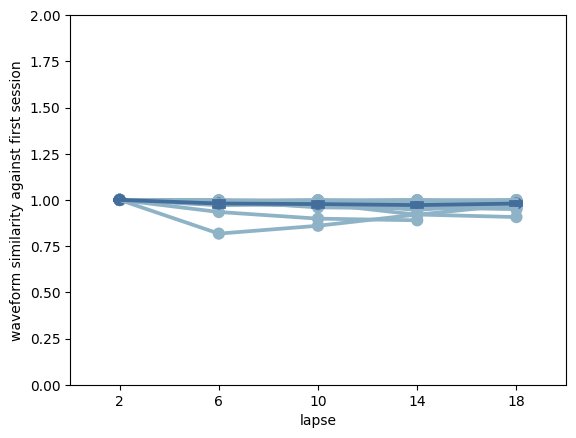

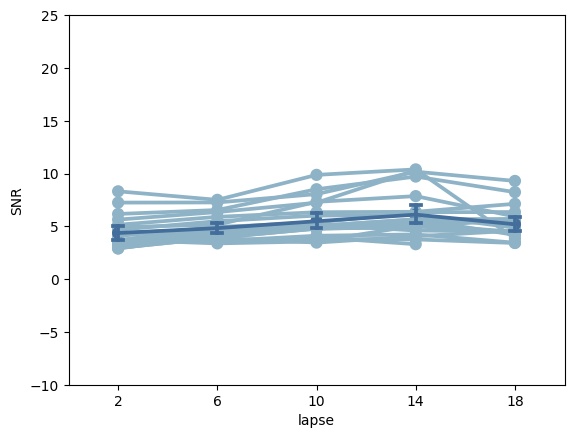

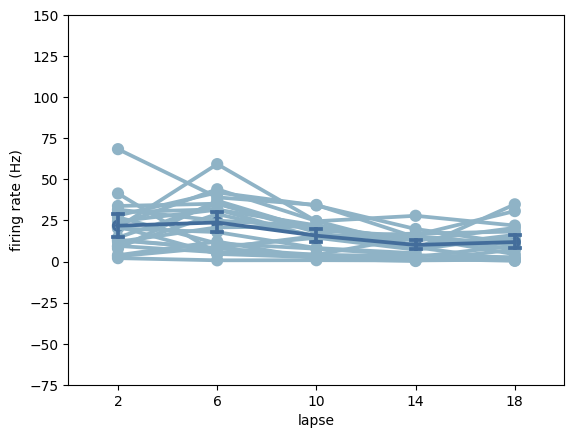

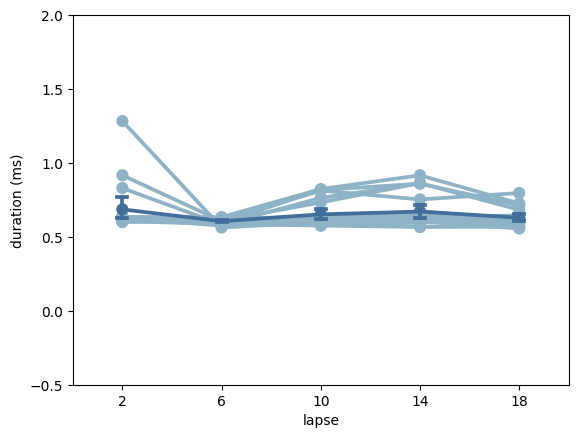

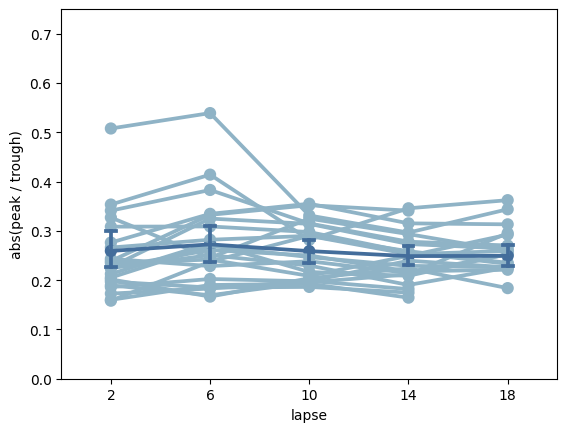

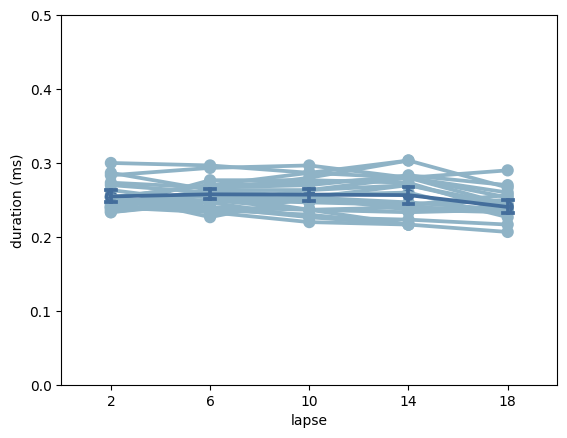

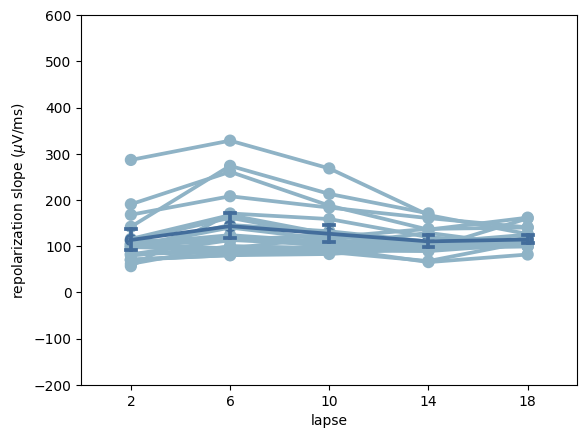

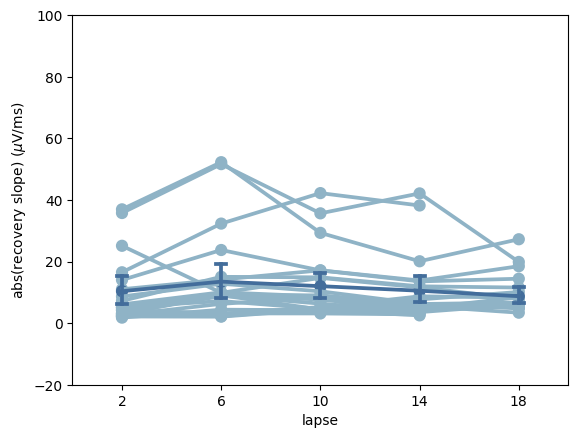

In [5]:
template_metrics = []
for (subject, surgery_date, n_segment), subject_curated_units in curated_units.items():
    surgery_date = datetime.datetime.strptime(surgery_date, '%Y%m%d')
    for shank, shank_curated_units in subject_curated_units.items():
        for unit_id, unit_segments in shank_curated_units.items():    
            session_info = pd.read_csv(f'data/processed/{subject}/shank{shank}/session_info.csv')
            segment_lapses = [2+4*round(((datetime.datetime.strptime(path.split('/')[3], '%Y%m%d')-surgery_date).days - 14) / 28) for path in session_info['segment_path']]
            recordings = [sc.load_extractor(f'data/processed/{subject}/shank{shank}/recording/segment{segment}') for segment in range(n_segment)]
            sortings = [se.NpzSortingExtractor(f'data/processed/{subject}/shank{shank}/sorting{threshold}/sorter_output/segment{segment}_firings.npz') for segment in range(n_segment)]
            waveform_extractors = [sc.load_waveforms(folder=f'data/processed/{subject}/shank{shank}/waveform{threshold}/segment{segment}', with_recording=False, sorting=sortings[segment]) for segment in range(n_segment)]

            extremum_channels = [sc.get_template_extremum_channel(waveform_extractors[segment])[unit_id] for segment in range(n_segment)]
            extremum_channels = [np.where(channel_indices[shank] == extremum_channel)[0].item() for extremum_channel in extremum_channels]
            extremum_templates = np.array([waveform_extractors[segment].get_template(unit_id=unit_id)[:, extremum_channels[segment]] for segment in range(n_segment)])

            for segment in unit_segments:
                waveform_extractors[segment].set_recording(recording=recordings[segment])
                unit_features = spost.compute_template_metrics(waveform_extractors[segment], peak_sign='neg').loc[[unit_id]]
                unit_features['lapse'] = segment_lapses[segment]
                unit_features['shank_unit_id'] = f'{shank}-{unit_id}'
                unit_features['peak_to_valley'] *= n_ms_per_s
                unit_features['peak_trough_ratio'] = np.abs(unit_features['peak_trough_ratio'])
                unit_features['half_width'] *= n_ms_per_s
                unit_features['repolarization_slope'] /= n_uV_per_mV
                unit_features['recovery_slope'] = np.abs(unit_features['recovery_slope']) / n_uV_per_mV
                unit_features['firing_rate'] = sqm.compute_firing_rates(waveform_extractors[segment], unit_ids=[unit_id])[unit_id]
                unit_features['signal_noise_ratio'] = sqm.compute_snrs(waveform_extractors[segment], unit_ids=[unit_id])[unit_id]
                unit_features['waveform_cosine_similarity'] = sklearn.metrics.pairwise.cosine_similarity([extremum_templates[unit_segments[0]]], [extremum_templates[segment]]).item()
                template_metrics.append(unit_features)
template_metrics = pd.concat(template_metrics, ignore_index=True)

ylabels = {
    'peak_to_valley': 'duration (ms)', 
    'peak_trough_ratio': 'abs(peak / trough)', 
    'half_width': 'duration (ms)', 
    'repolarization_slope': r'repolarization slope ($\mu$V/ms)', 
    'recovery_slope': r'abs(recovery slope) ($\mu$V/ms)', 
    'firing_rate': 'firing rate (Hz)',
    'signal_noise_ratio': 'SNR',
    'waveform_cosine_similarity': 'waveform similarity against first session'
}
ylims = {
    'peak_to_valley': (-0.5, 2), 
    'peak_trough_ratio': (0, 0.75), 
    'half_width': (0, 0.5), 
    'repolarization_slope': (-200, 600), 
    'recovery_slope': (-20, 100), 
    'firing_rate': (-75, 150),
    'signal_noise_ratio': (-10, 25),
    'waveform_cosine_similarity': (0, 2),
}
for feature in ['waveform_cosine_similarity', 'signal_noise_ratio', 'firing_rate', 'peak_to_valley', 'peak_trough_ratio', 'half_width', 'repolarization_slope', 'recovery_slope']:
    plt.figure()
    ax = plt.gca()
    for shank_unit_id in template_metrics['shank_unit_id'].unique():
        unit_features = template_metrics[template_metrics['shank_unit_id'] == shank_unit_id]
        sns.pointplot(data=unit_features, x='lapse', y=feature, color='#8FB3C6', ax=ax)
    sns.pointplot(data=template_metrics, x='lapse', y=feature, color='#436D9B', capsize=0.1, ax=ax)
    plt.ylim(*ylims[feature])
    plt.ylabel(ylabels[feature])
    plt.savefig(f'{figure_folder}/{feature}.pdf')
    plt.show()
    plt.close()

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


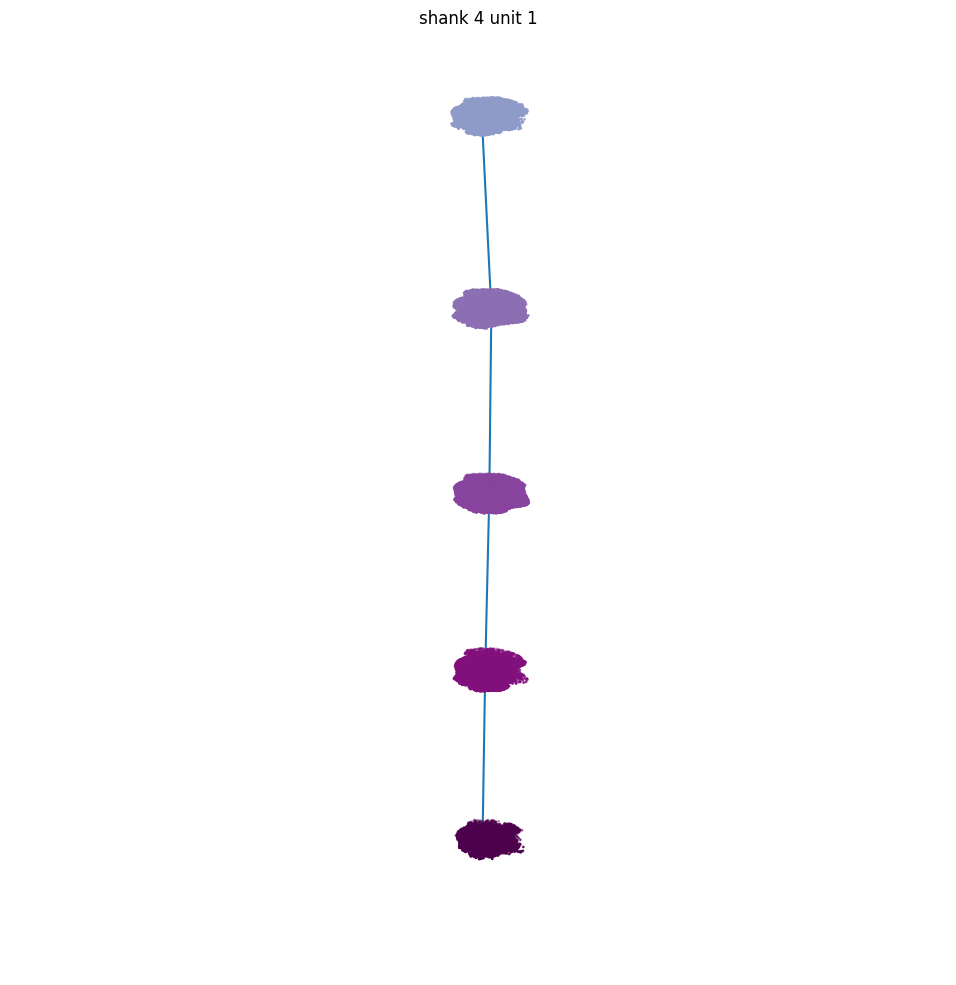

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


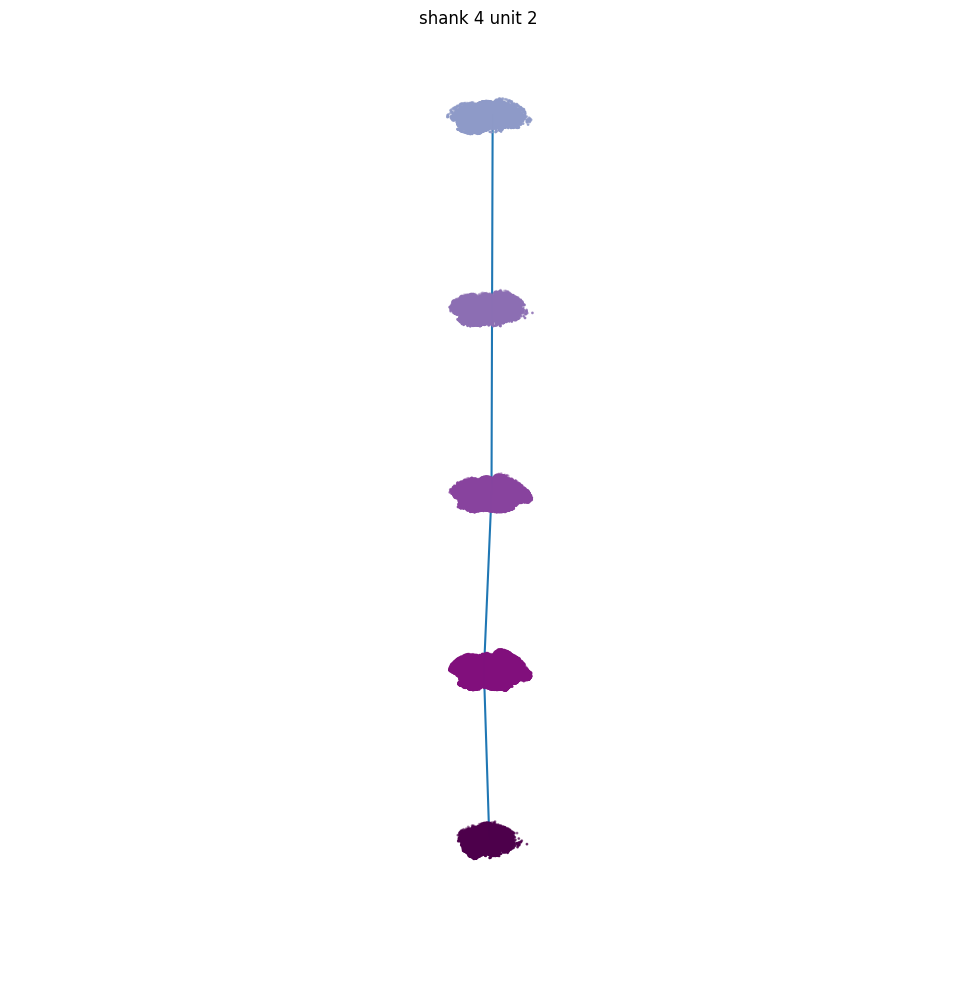

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


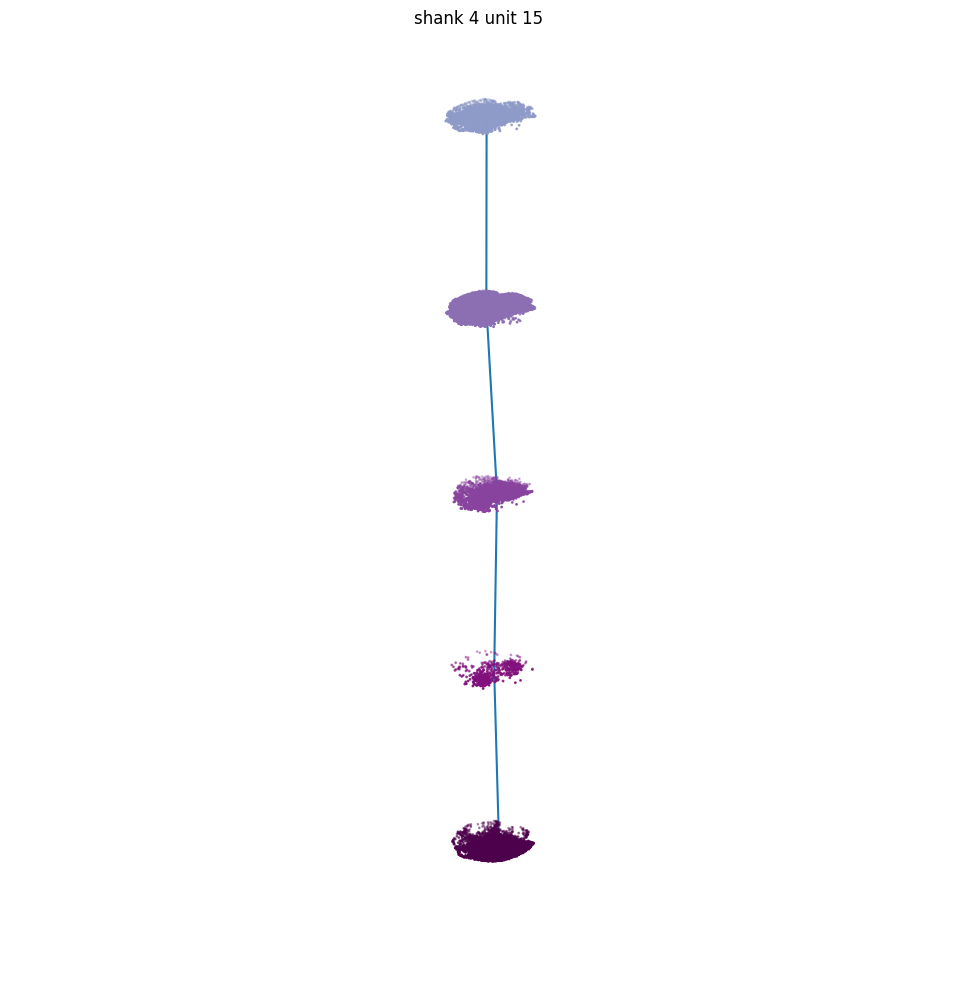

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


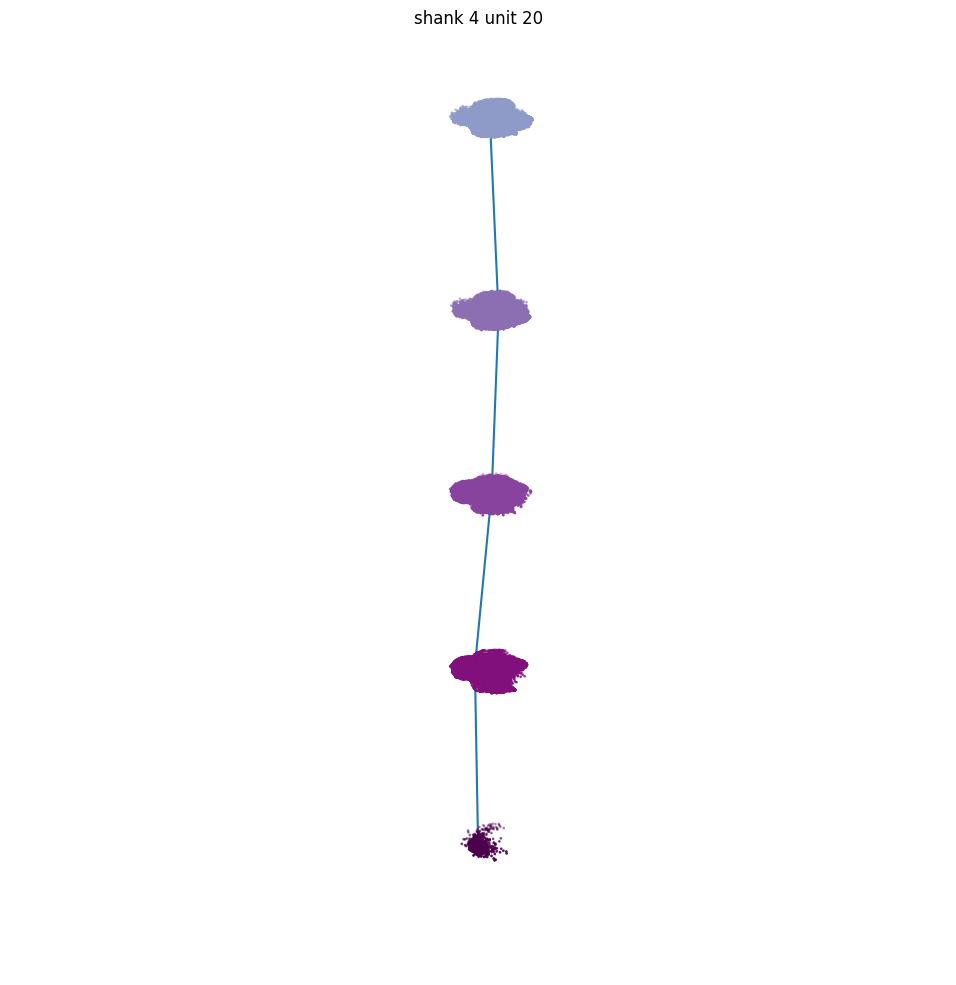

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_269115/2050680869.py:43: RuntimeWarning: Mean of empty slice.
  means.append([lapse_adata.obsm['X_umap'][:, 0].mean(), lapse_adata.obsm['X_umap'][:, 1].mean(), plot_index * shank_gap])
/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


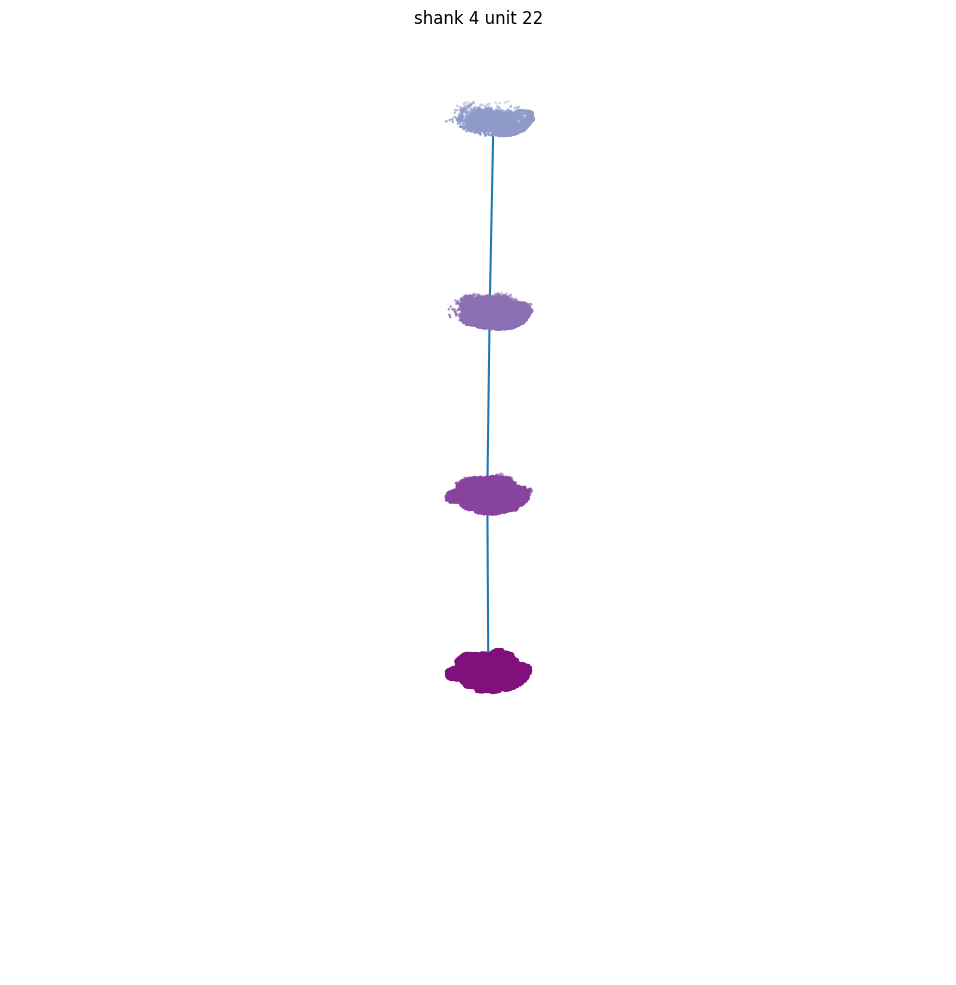

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


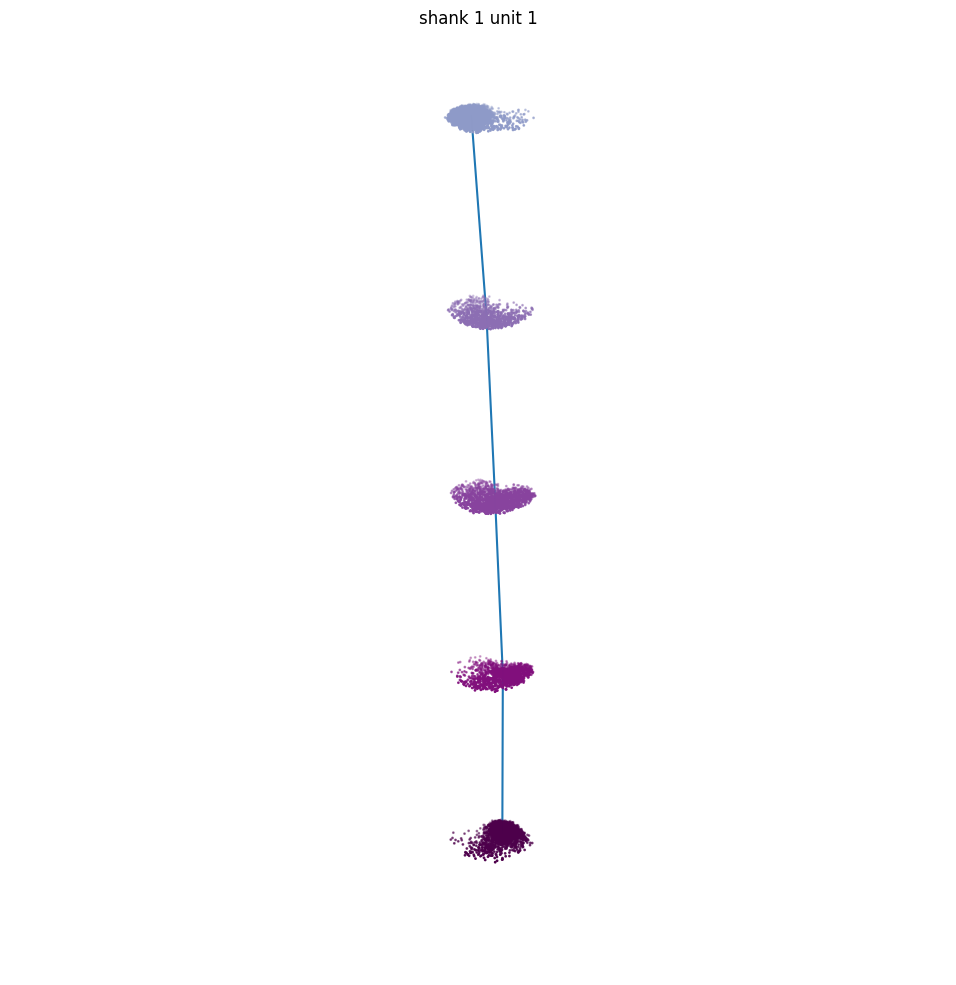

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_269115/2050680869.py:43: RuntimeWarning: Mean of empty slice.
  means.append([lapse_adata.obsm['X_umap'][:, 0].mean(), lapse_adata.obsm['X_umap'][:, 1].mean(), plot_index * shank_gap])
/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


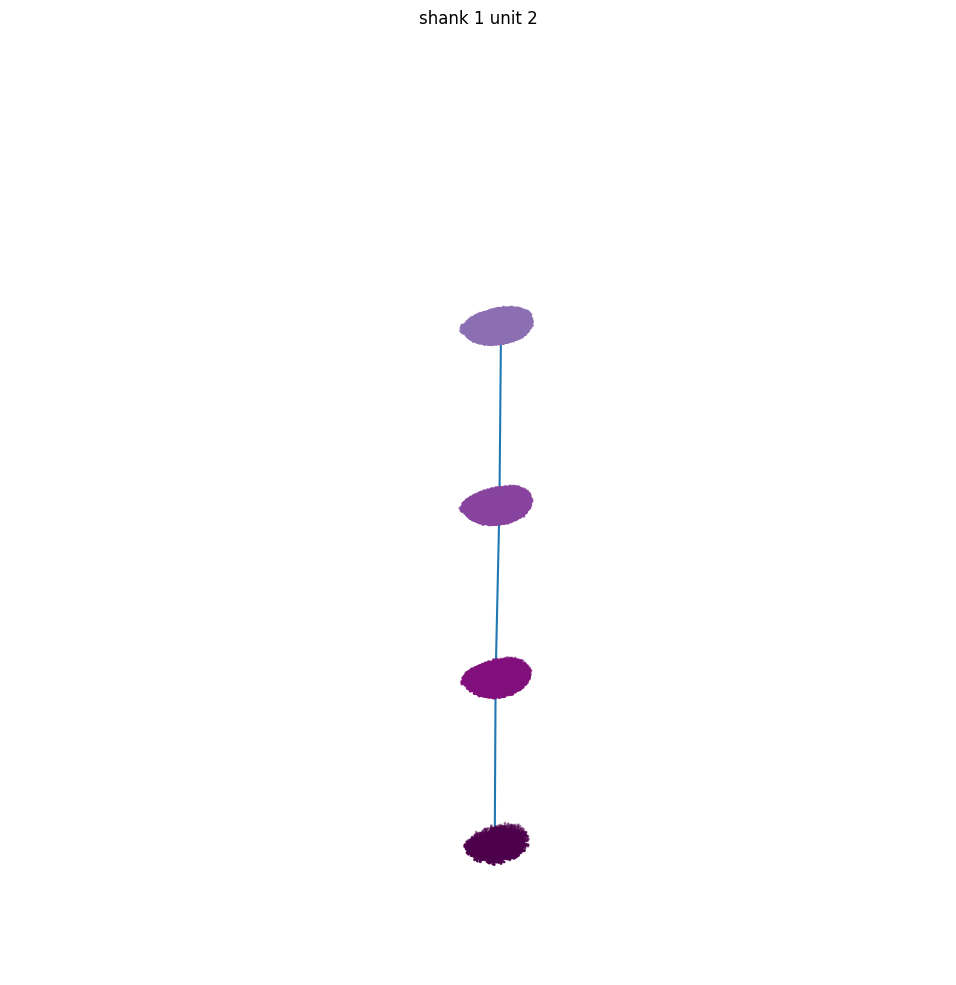

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


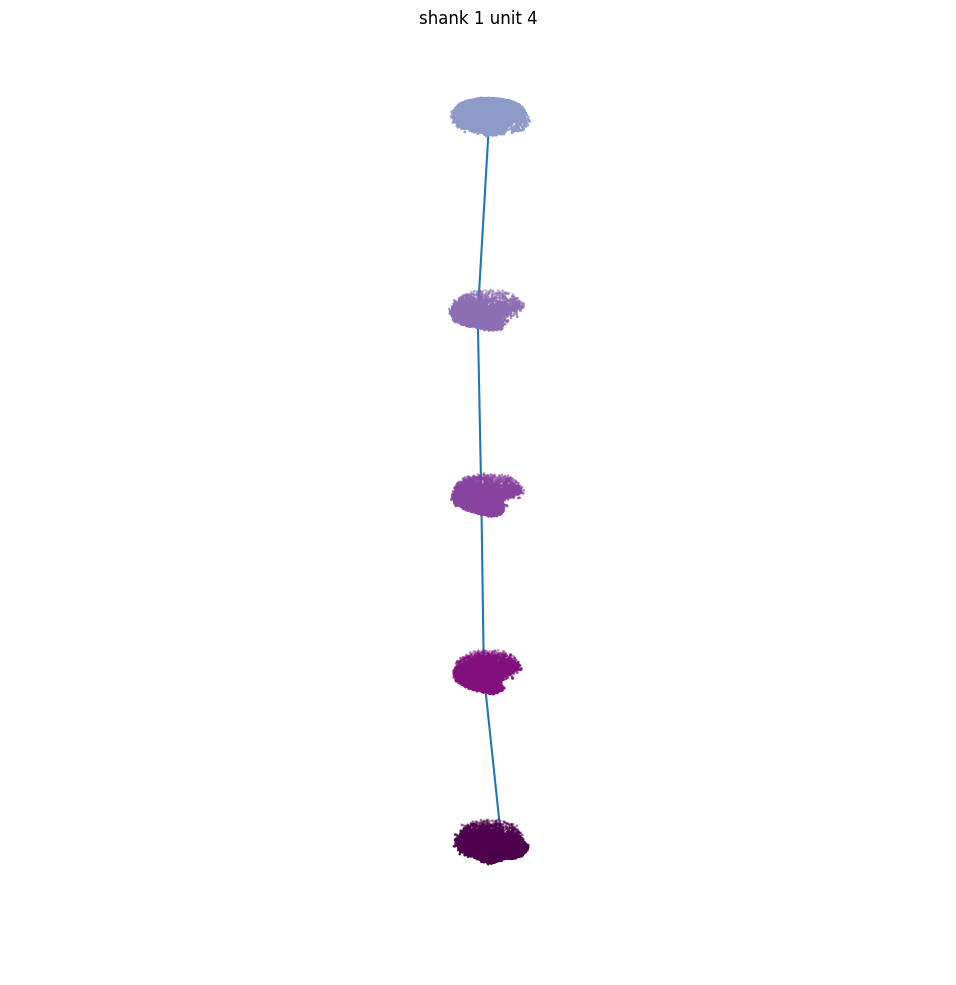

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


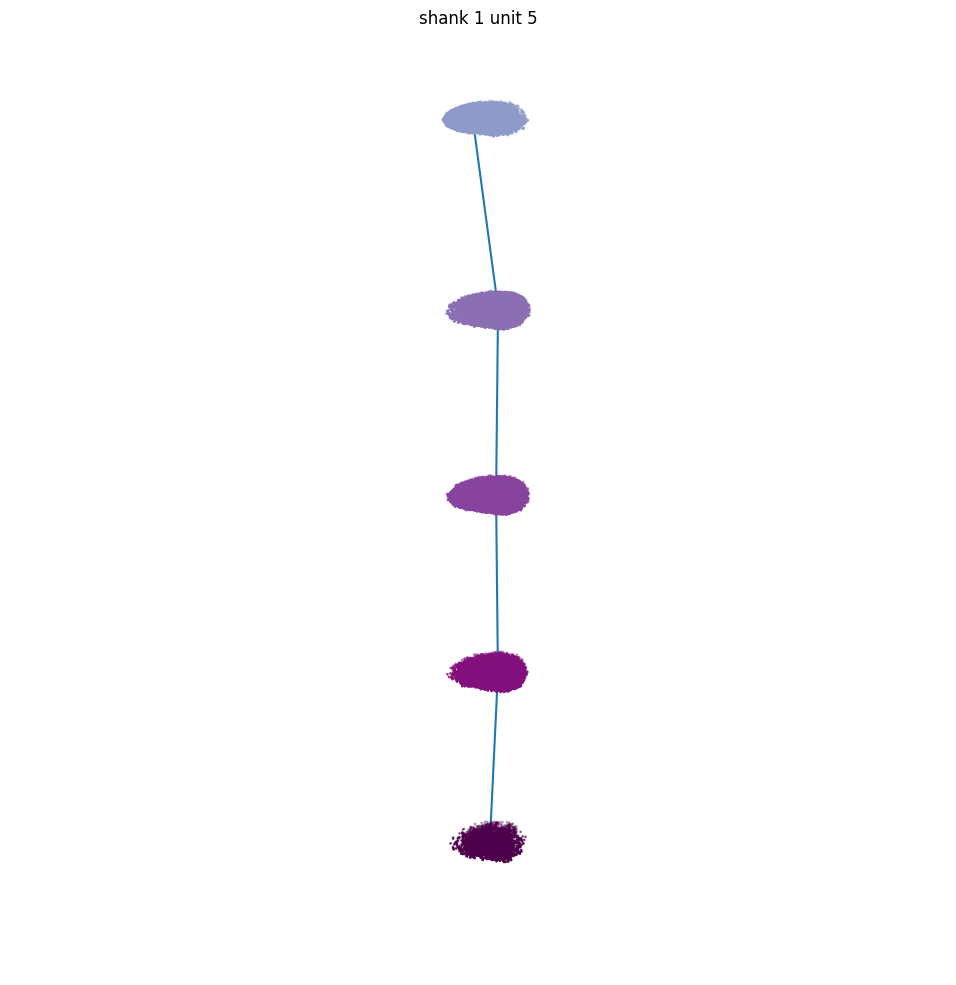

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_269115/2050680869.py:43: RuntimeWarning: Mean of empty slice.
  means.append([lapse_adata.obsm['X_umap'][:, 0].mean(), lapse_adata.obsm['X_umap'][:, 1].mean(), plot_index * shank_gap])
/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


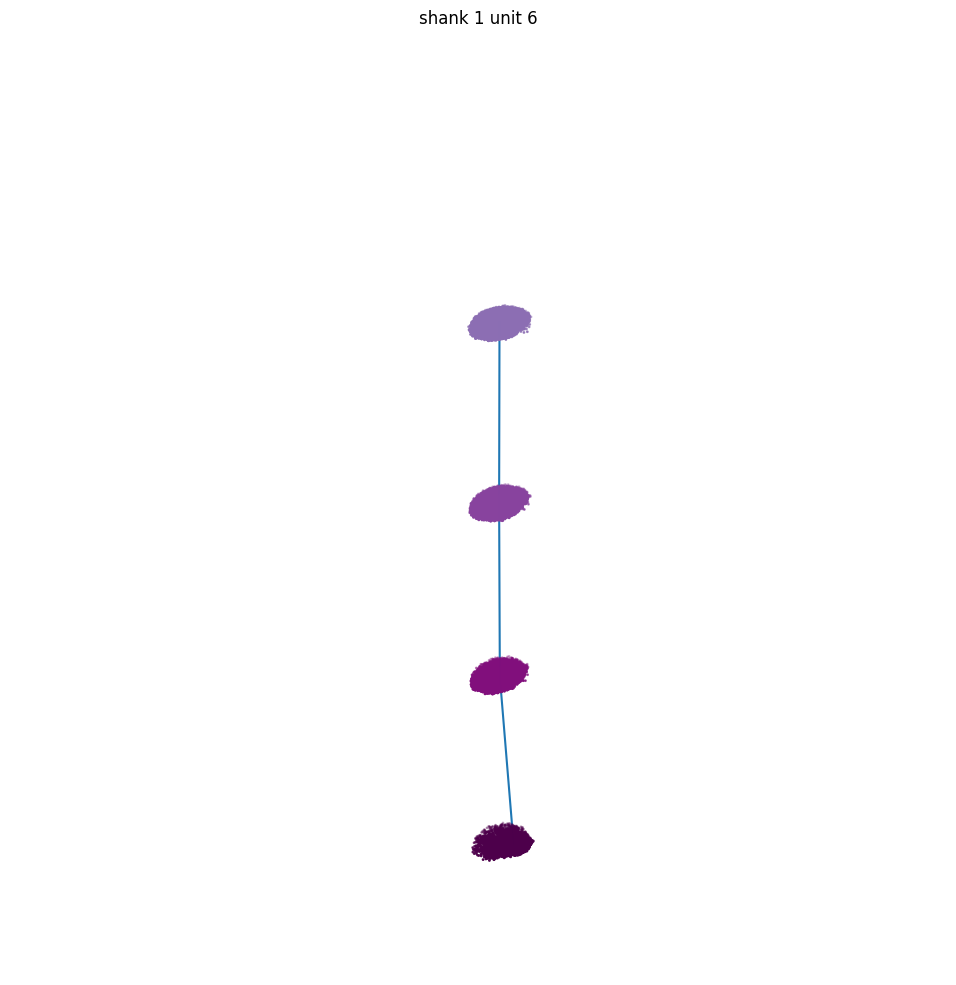

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


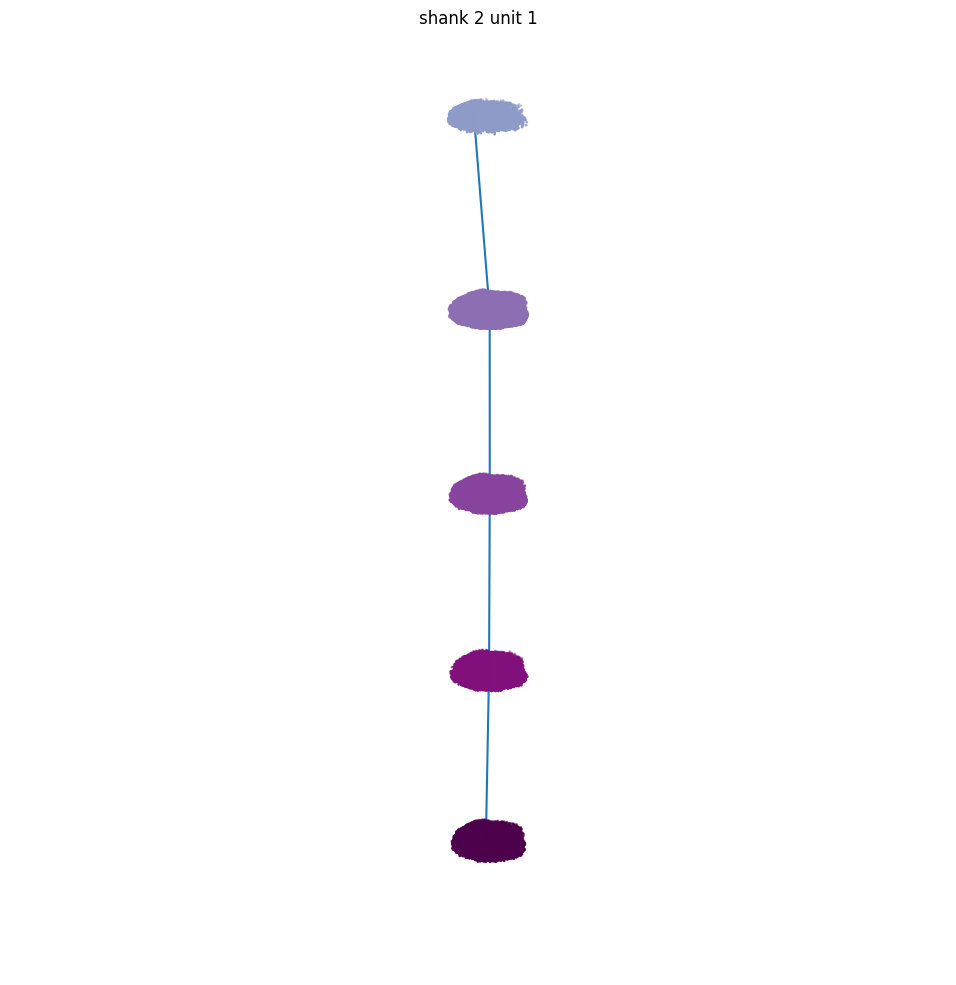

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


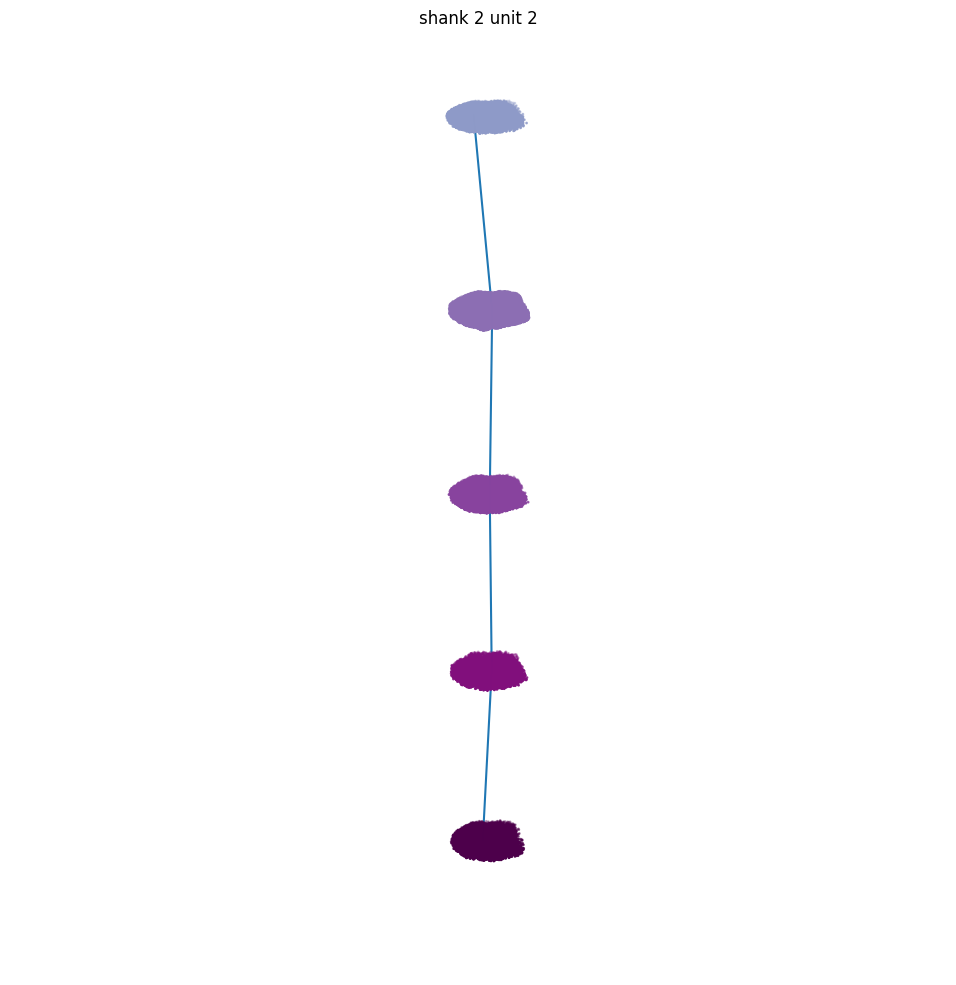

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


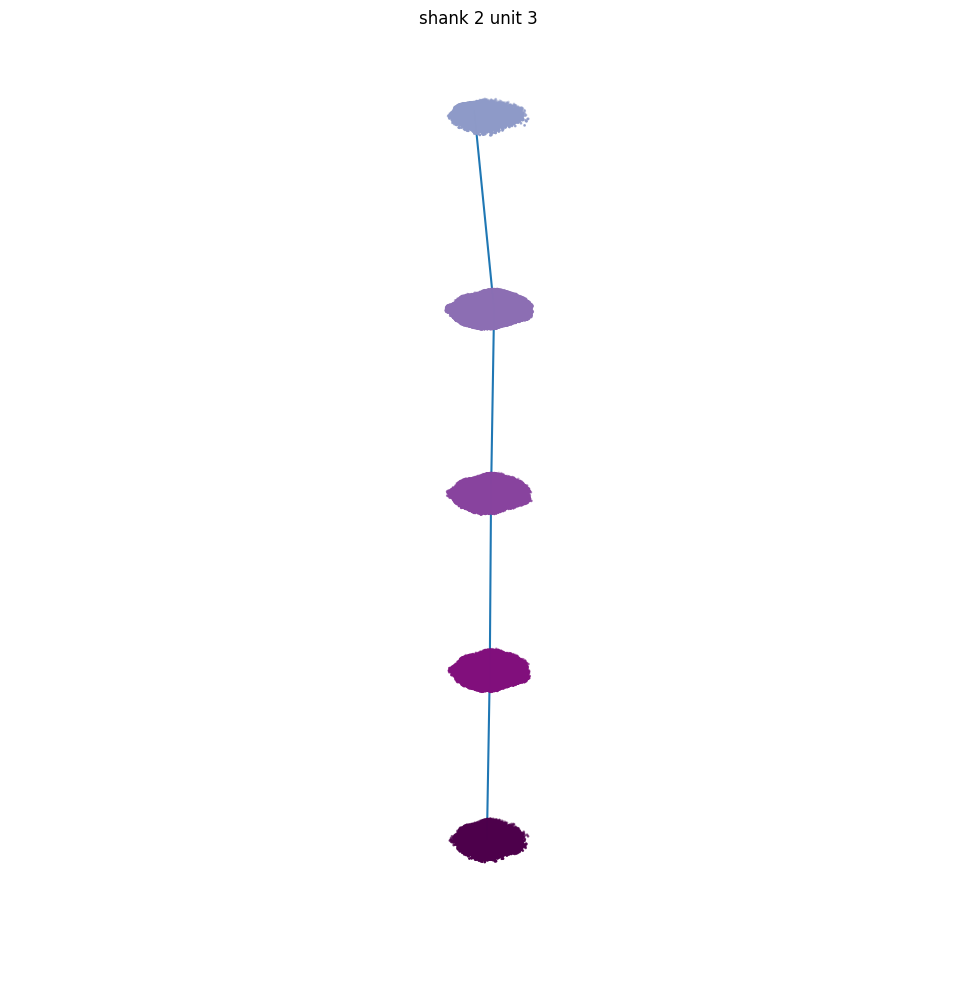

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


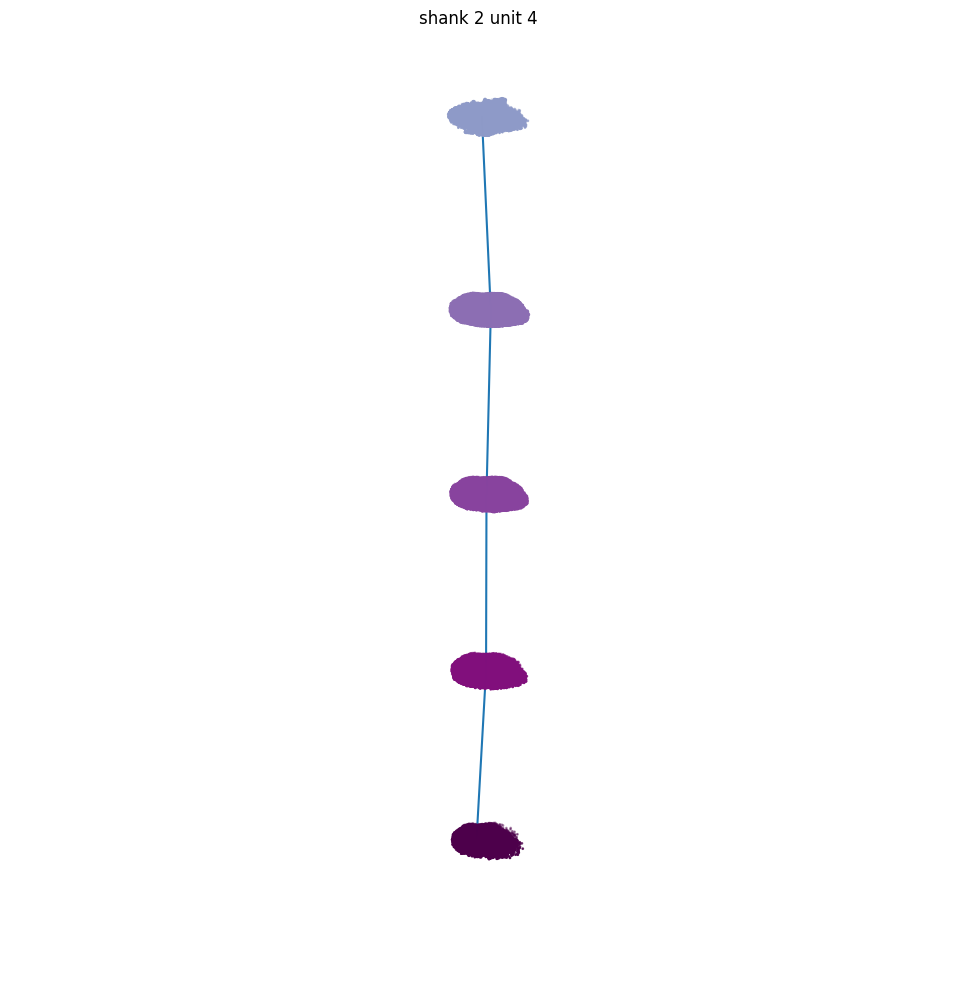

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


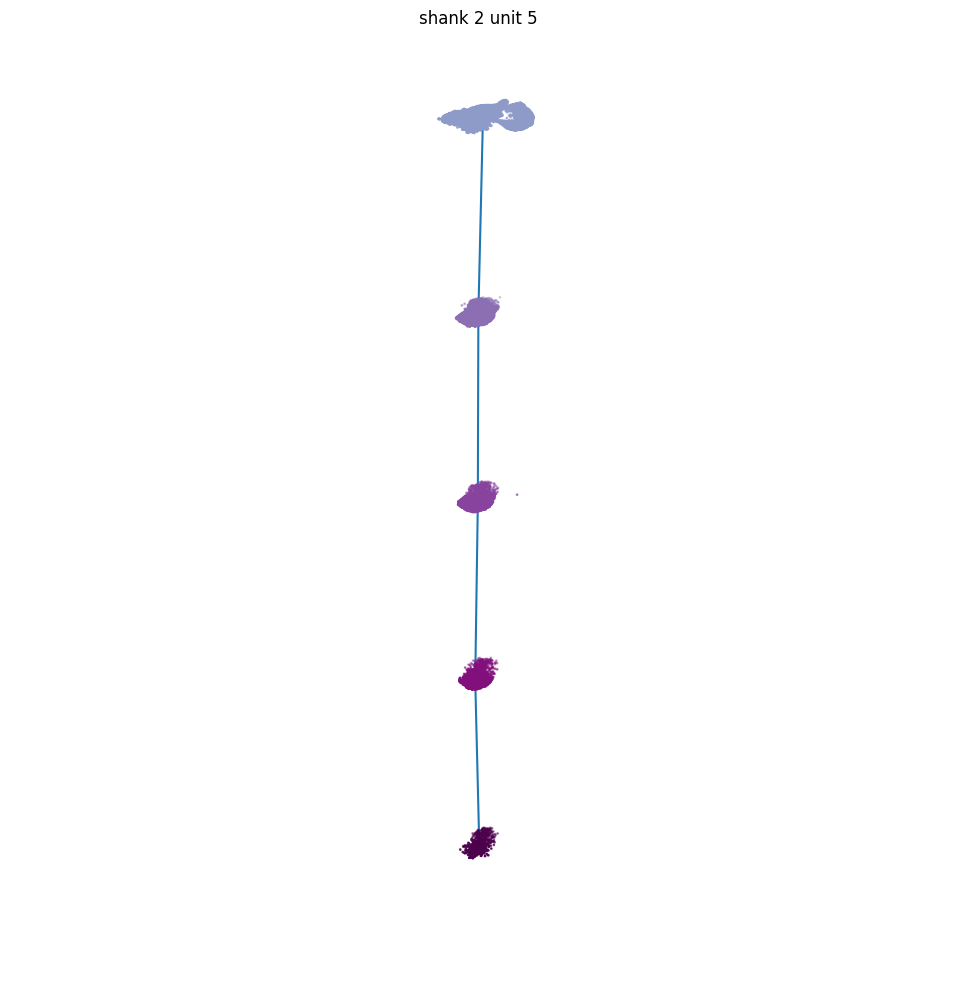

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


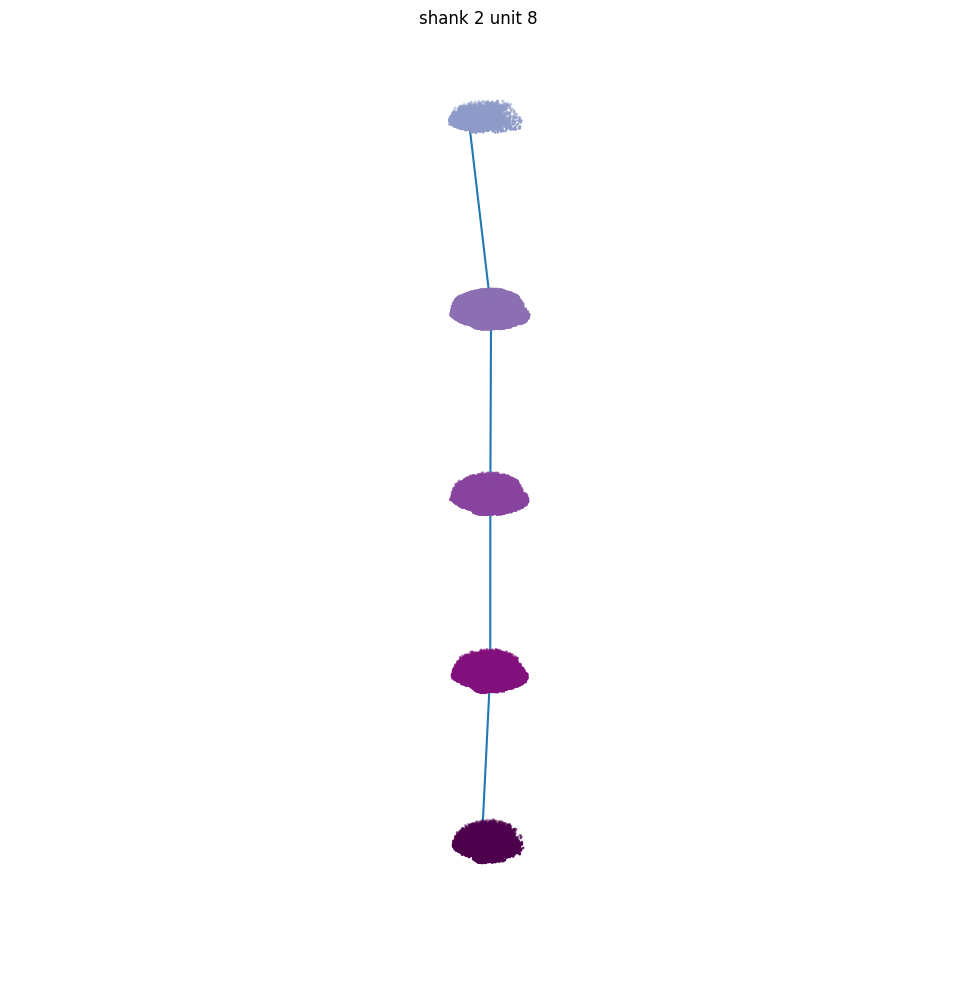

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


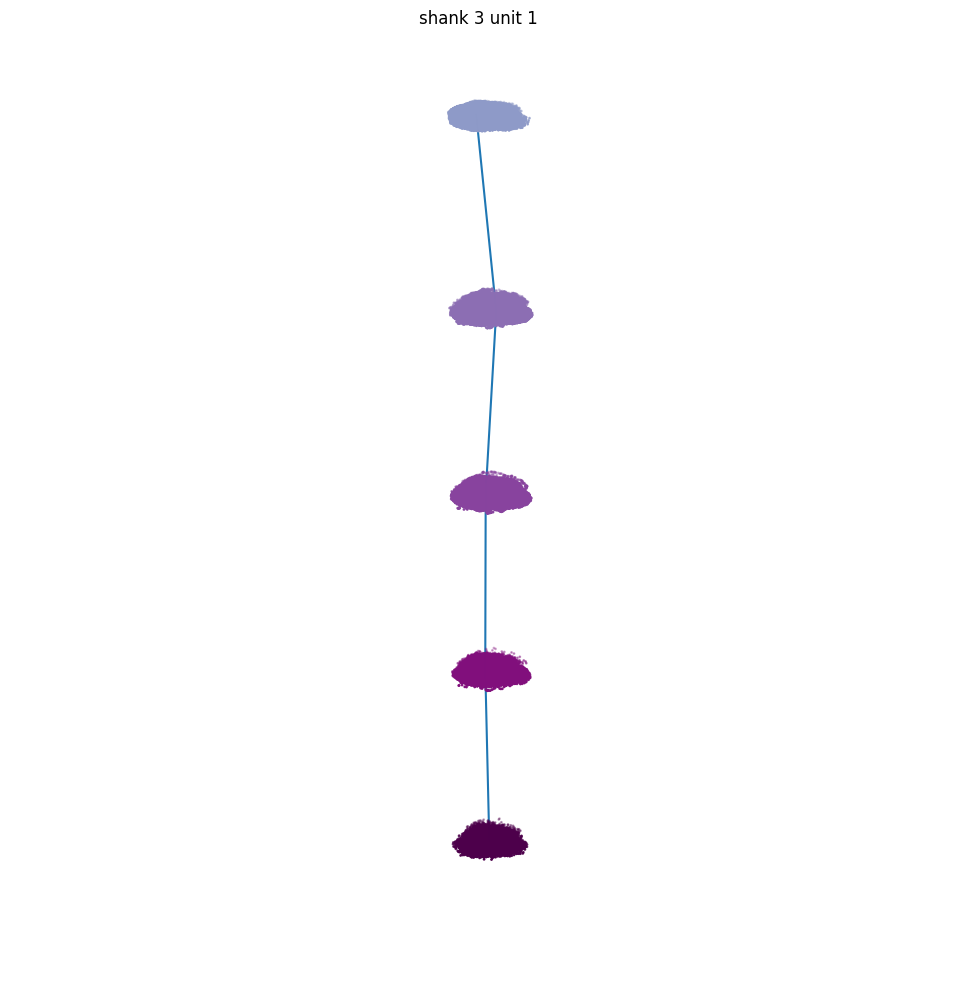

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


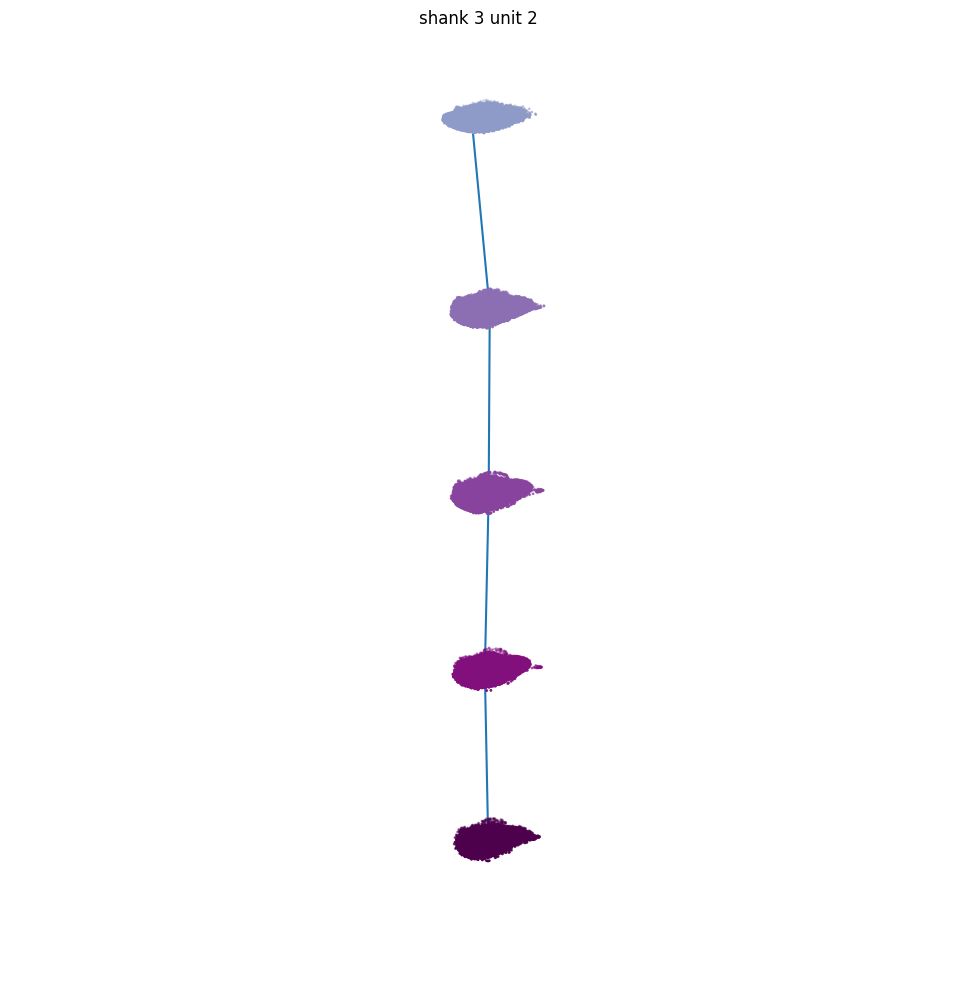

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_269115/2050680869.py:43: RuntimeWarning: Mean of empty slice.
  means.append([lapse_adata.obsm['X_umap'][:, 0].mean(), lapse_adata.obsm['X_umap'][:, 1].mean(), plot_index * shank_gap])
/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


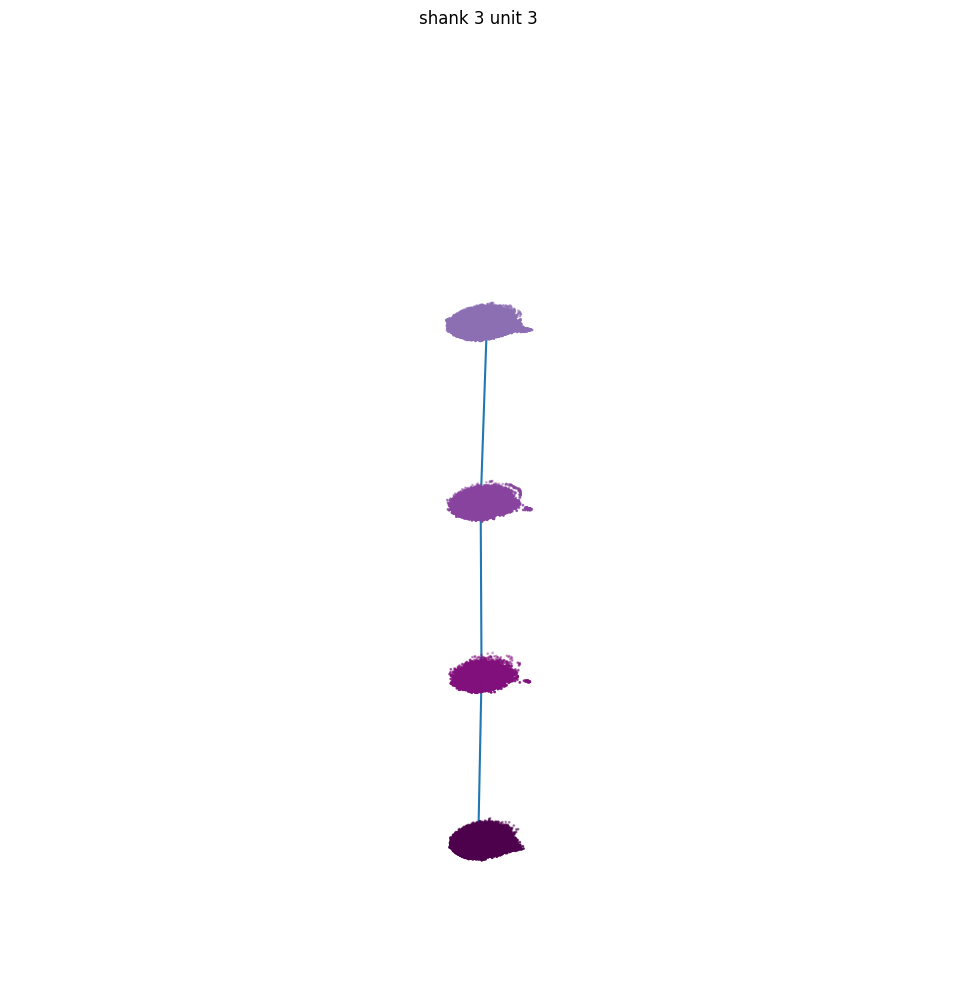

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


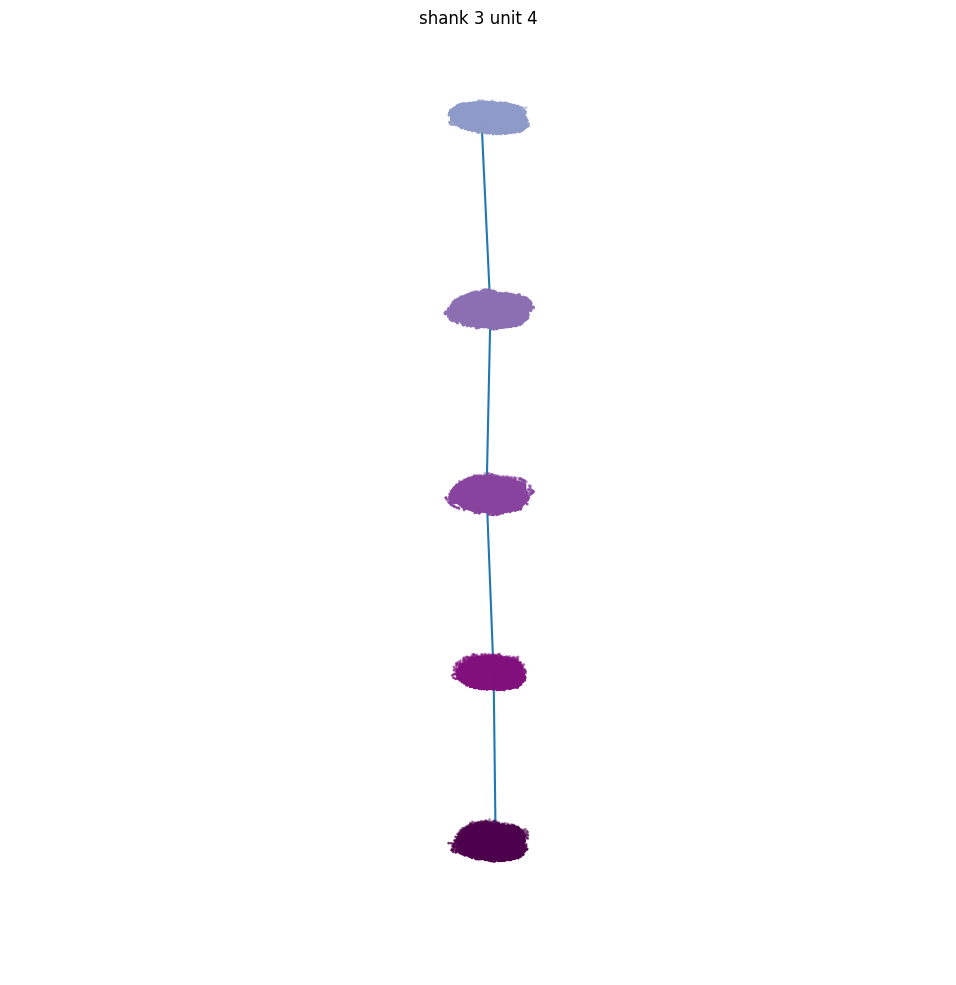

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


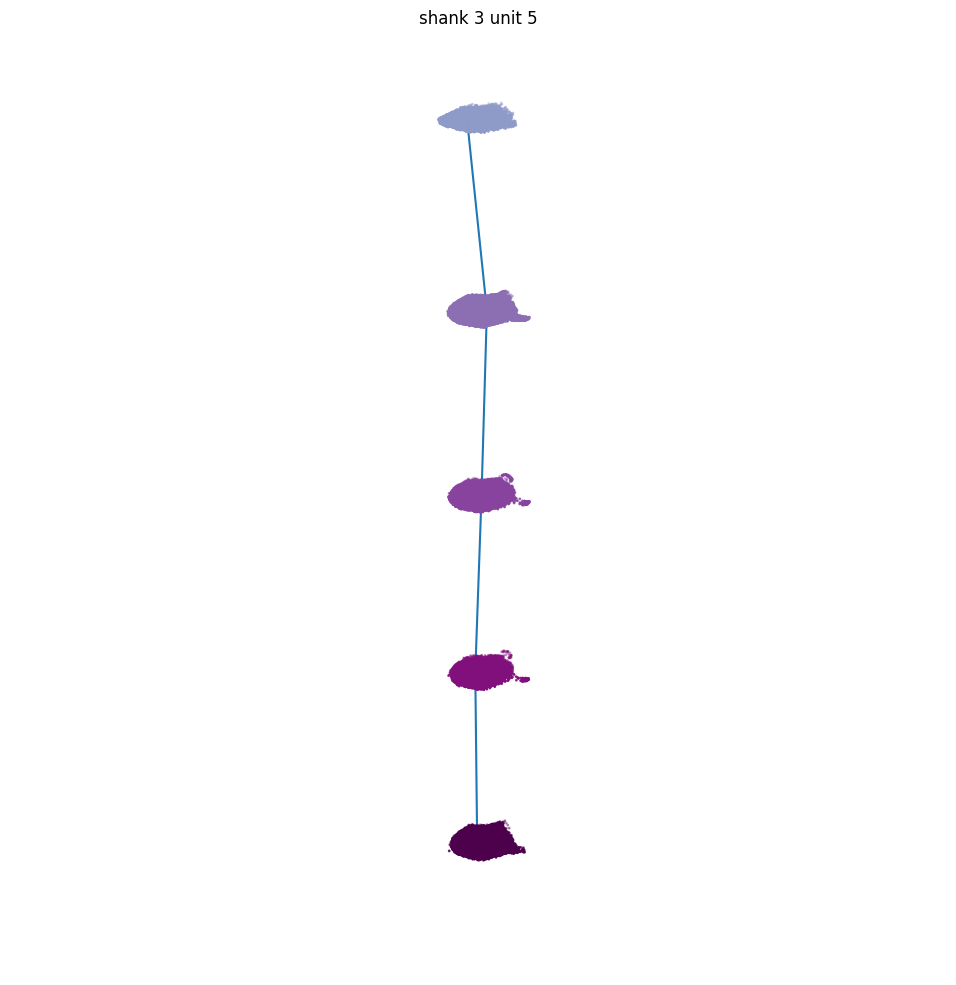

/home/xinhez/miniconda3/envs/si-0.98.2/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


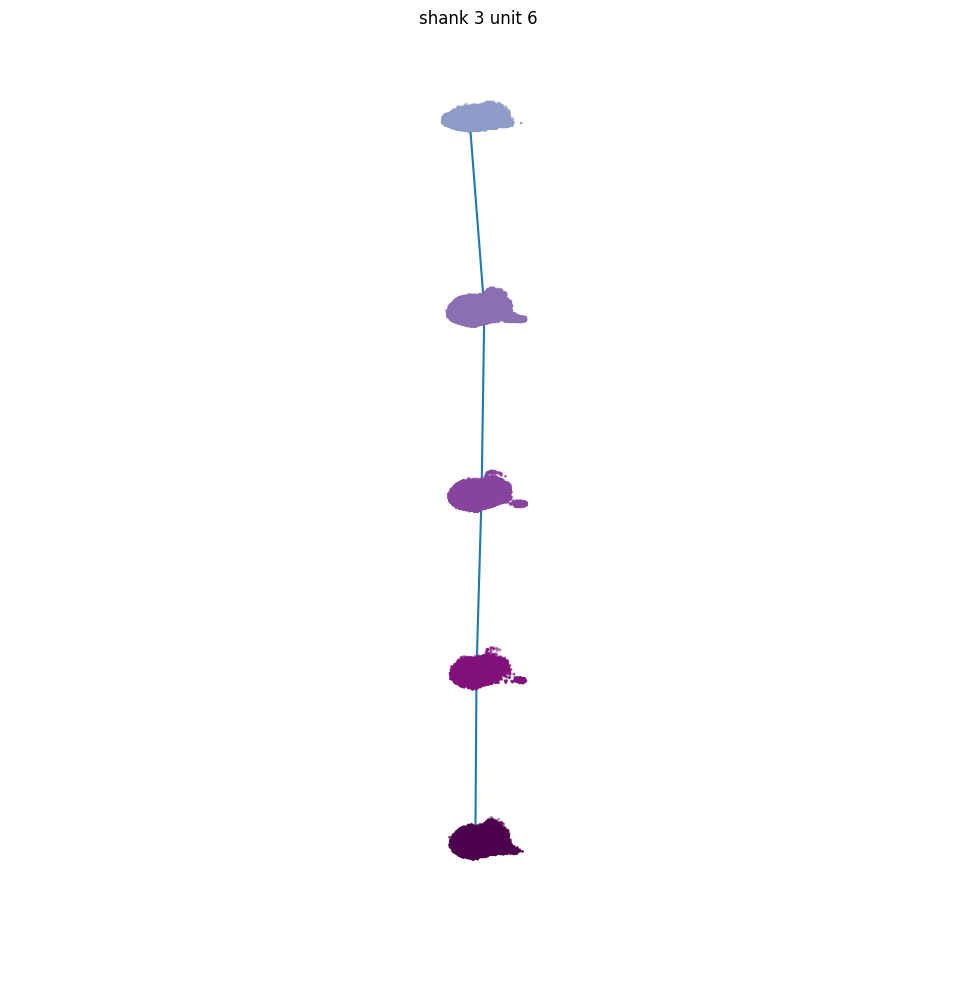

In [7]:
for (subject, surgery_date, n_segment), subject_curated_units in curated_units.items():
    surgery_date = datetime.datetime.strptime(surgery_date, '%Y%m%d')
    for shank, shank_curated_units in subject_curated_units.items():
        for unit_id, unit_segments in shank_curated_units.items():    
            session_info = pd.read_csv(f'data/processed/{subject}/shank{shank}/session_info.csv')
            segment_lapses = [2+4*round(((datetime.datetime.strptime(path.split('/')[3], '%Y%m%d')-surgery_date).days - 14) / 28) for path in session_info['segment_path']]
            recordings = [sc.load_extractor(f'data/processed/{subject}/shank{shank}/recording/segment{segment}') for segment in range(n_segment)]
            sortings = [se.NpzSortingExtractor(f'data/processed/{subject}/shank{shank}/sorting{threshold}/sorter_output/segment{segment}_firings.npz') for segment in range(n_segment)]
            waveform_extractors = [sc.load_waveforms(folder=f'data/processed/{subject}/shank{shank}/waveform{threshold}/segment{segment}', with_recording=False, sorting=sortings[segment]) for segment in range(n_segment)]

            xs, labels = [], []
            for segment in unit_segments:
                segment_waveforms = waveform_extractors[segment].get_waveforms(unit_id=unit_id)
                segment_waveforms = segment_waveforms.reshape(segment_waveforms.shape[0], segment_waveforms.shape[1]*segment_waveforms.shape[2])
                xs.append(segment_waveforms)
                labels.append([segment_lapses[segment]] * len(segment_waveforms))
            xs = np.vstack(xs)
            labels = np.hstack(labels)
            unit_adata = ad.AnnData(X=xs, obs=pd.DataFrame({'lapse': labels}))
            scanpy.pp.neighbors(unit_adata, use_rep='X')
            scanpy.tl.umap(unit_adata)

            
            fig = plt.figure(figsize=(10, 10))
            fig.suptitle(f'shank {shank} unit {unit_id}')
            ax = plt.subplot(projection='3d')
            ax.set_box_aspect((1, 1, 10))
            ax.grid(False)
            ax.xaxis.pane.fill = False
            ax.yaxis.pane.fill = False
            ax.zaxis.pane.fill = False
            ax.xaxis.pane.set_edgecolor('w')
            ax.yaxis.pane.set_edgecolor('w')
            ax.zaxis.pane.set_edgecolor('w')

            shank_gap = -10
            means = []
            for plot_index, lapse in enumerate(lapses_plotted):
                lapse_adata = unit_adata[unit_adata.obs['lapse'] == lapse]
                
                ax.scatter3D(lapse_adata.obsm['X_umap'][:, 0], lapse_adata.obsm['X_umap'][:, 1], plot_index * shank_gap, s=1, color=plt.cm.BuPu(0.42 + 0.58 * lapse / n_total_lapse))
                
                means.append([lapse_adata.obsm['X_umap'][:, 0].mean(), lapse_adata.obsm['X_umap'][:, 1].mean(), plot_index * shank_gap])
                
            means = np.array(means)
            ax.plot3D(means[:, 0], means[:, 1], means[:, 2])
            ax.set_axis_off()
            for lapse_index, ticklabel in enumerate(ax.get_zticklabels()):
                ticklabel.set_color(plt.cm.BuPu(0.42 + 0.58 * lapses_plotted[lapse_index] / n_total_lapse))
            plt.tight_layout()
            plt.savefig(f'{figure_folder}/umap_shank{shank}_unit{unit_id}.pdf')
            plt.savefig(f'{figure_folder}/umap_shank{shank}_unit{unit_id}.eps')
            plt.savefig(f'{figure_folder}/umap_shank{shank}_unit{unit_id}.svg')
            plt.savefig(f'{figure_folder}/umap_shank{shank}_unit{unit_id}.png', dpi=1200, transparent=True)
            plt.show()
            plt.close()